# Setup

In [11]:
import pandas as pd
import numpy as np
import os


# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 18

plt.style.use('fivethirtyeight')

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=400):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


PROCESSED_PATH = os.path.join(PROJECT_ROOT_DIR, "processed")
def save_processed(df, filename, extension="csv"):
    if not os.path.isdir(PROCESSED_PATH):
        os.makedirs(PROCESSED_PATH)
    path = os.path.join(PROCESSED_PATH, filename + "." + extension)
    print("Saving processed dataset", filename)
    df.to_csv(path, index=False)
    
# if less than R1K, show as R800 (for eg). If btw R1000 and R999,999, show as R1K or R999K. If R1,000,000 or greater, show as R1M
def currency_formatter(x, pos):
    if x >= 1000000:
        return 'R%1.1fM' % (x * 1e-6)
    elif x < 1000:
        return 'R%1.1d' % (x)
    else:
        return 'R%1.1dK' % (x * 1e-3) 
    
axes_formatter = FuncFormatter(currency_formatter) 

RAW_FOLDER = "raw/"
PROCESSED_FOLDER = "processed/"

# Useful Functions for Analysis

In [3]:
def top(df, n=5, column='aggregate_rating'):
    '''Returns the top n rows of data set df ordered desc'''
    return df.sort_values(by=column, ascending=False)[:n]

def bottom(df, n=5, column='aggregate_rating'):
    '''Returns the bottoms n rows of data set df ordered asc'''
    return df.sort_values(by=column, ascending=True)[:n]

def get_stats(group):
    '''Returns the min, max, count and mean summary statistics for a grouped data set'''
    return {'min': group.min(), 'max': group.max(), 'count': group.count(),
            'mean': group.mean(), 'median': group.median(), 'std': group.std()} 

def get_cuisine_cols():
    cols = ["name", "aggregate_rating", "rating_text", "votes", "average_cost_for_two", "price_range", "cuisines", "cuisine_count", "places", "locality", "region", "city", "latitude", "longitude", "has_online_delivery", "has_table_booking", "top_bottom"]
    '''Returns the column names of all the cuisine type column, not including the cuisine_count column'''
    cuisine_cols = [col for col in data.columns.tolist() if col not in cols]
    return cuisine_cols  

In [5]:
# Used to explore a single feature on a set of subplots. 
# Visualise distribution, noise & outliers and missing values as well as correlation with target.
def explore_variable(df, feature, target=None, by_categorical=None):
    '''
    Numerical features will display 3 plots: histogram, correlation between source feature and a target and a box plot for feature. 
    Optional by_categorical can be provided to show box plot by levels of a categorical variable.
    Categorical features will display 2 plots: bar chart of levels, median of target by feature levels.
    '''    
    feature_type = df[feature].dtype
    missing = df.apply(lambda x: sum(x.isnull())).loc[feature]
    print("'{}' is of type {} with {} missing values".format(feature, feature_type, missing))

    if feature_type == "object":
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].value_counts().plot.barh(ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Median {} by {}".format(target, feature))
#         df.groupby(feature)[[target]].median().plot.barh(ax=ax2)
        if by_categorical is not None:
            pd.pivot_table(data=df, index=feature, values=target, columns=by_categorical).plot.barh(ax=ax2)
        else:
            pd.pivot_table(data=df, index=feature, values=target).plot.barh(ax=ax2)

        plt.show()

    elif feature_type == "int64" or "float64":
        if target is not None:
            fig, ax = plt.subplots(1, 3, figsize=(20,8), dpi=400)
            fig.subplots_adjust(wspace=0.3)

            ax1 = ax.ravel()[0]
            ax1.set_title("Distribution of {}".format(feature))
            df[feature].hist(bins=50, ax=ax1)

            ax2 = ax.ravel()[1]
            ax2.set_title("Correlation btw\n {} and {}".format(feature, target))
            df.plot.scatter(x=feature, y=target, ax=ax2)  

            ax3 = ax.ravel()[2]
            ax3.set_title("Box plot for {}".format(feature))
            #df[feature].plot.box(ax=ax3)
            if by_categorical is not None:
                sns.boxplot(x=by_categorical, y=feature, data=df, ax=ax3)
            else:
                sns.boxplot(y=df[feature], ax=ax3)
        else:
            fig, ax = plt.subplots(1, 2, figsize=(20,8), dpi=400)
            fig.subplots_adjust(wspace=0.3)

            ax1 = ax.ravel()[0]
            ax1.set_title("Distribution of {}".format(feature))
            df[feature].hist(bins=50, ax=ax1)

            ax2 = ax.ravel()[1]
            ax2.set_title("Box plot for {}".format(feature))
            #df[feature].plot.box(ax=ax3)
            if by_categorical is not None:
                sns.boxplot(x=by_categorical, y=feature, data=df, ax=ax2)
            else:
                sns.boxplot(y=df[feature], ax=ax2) 

        plt.show()

# Exploratory Data Analysis
Before we look for specific trends we'll give ourselves a better understanding of our dataset.

'aggregate_rating' is of type float64 with 0 missing values


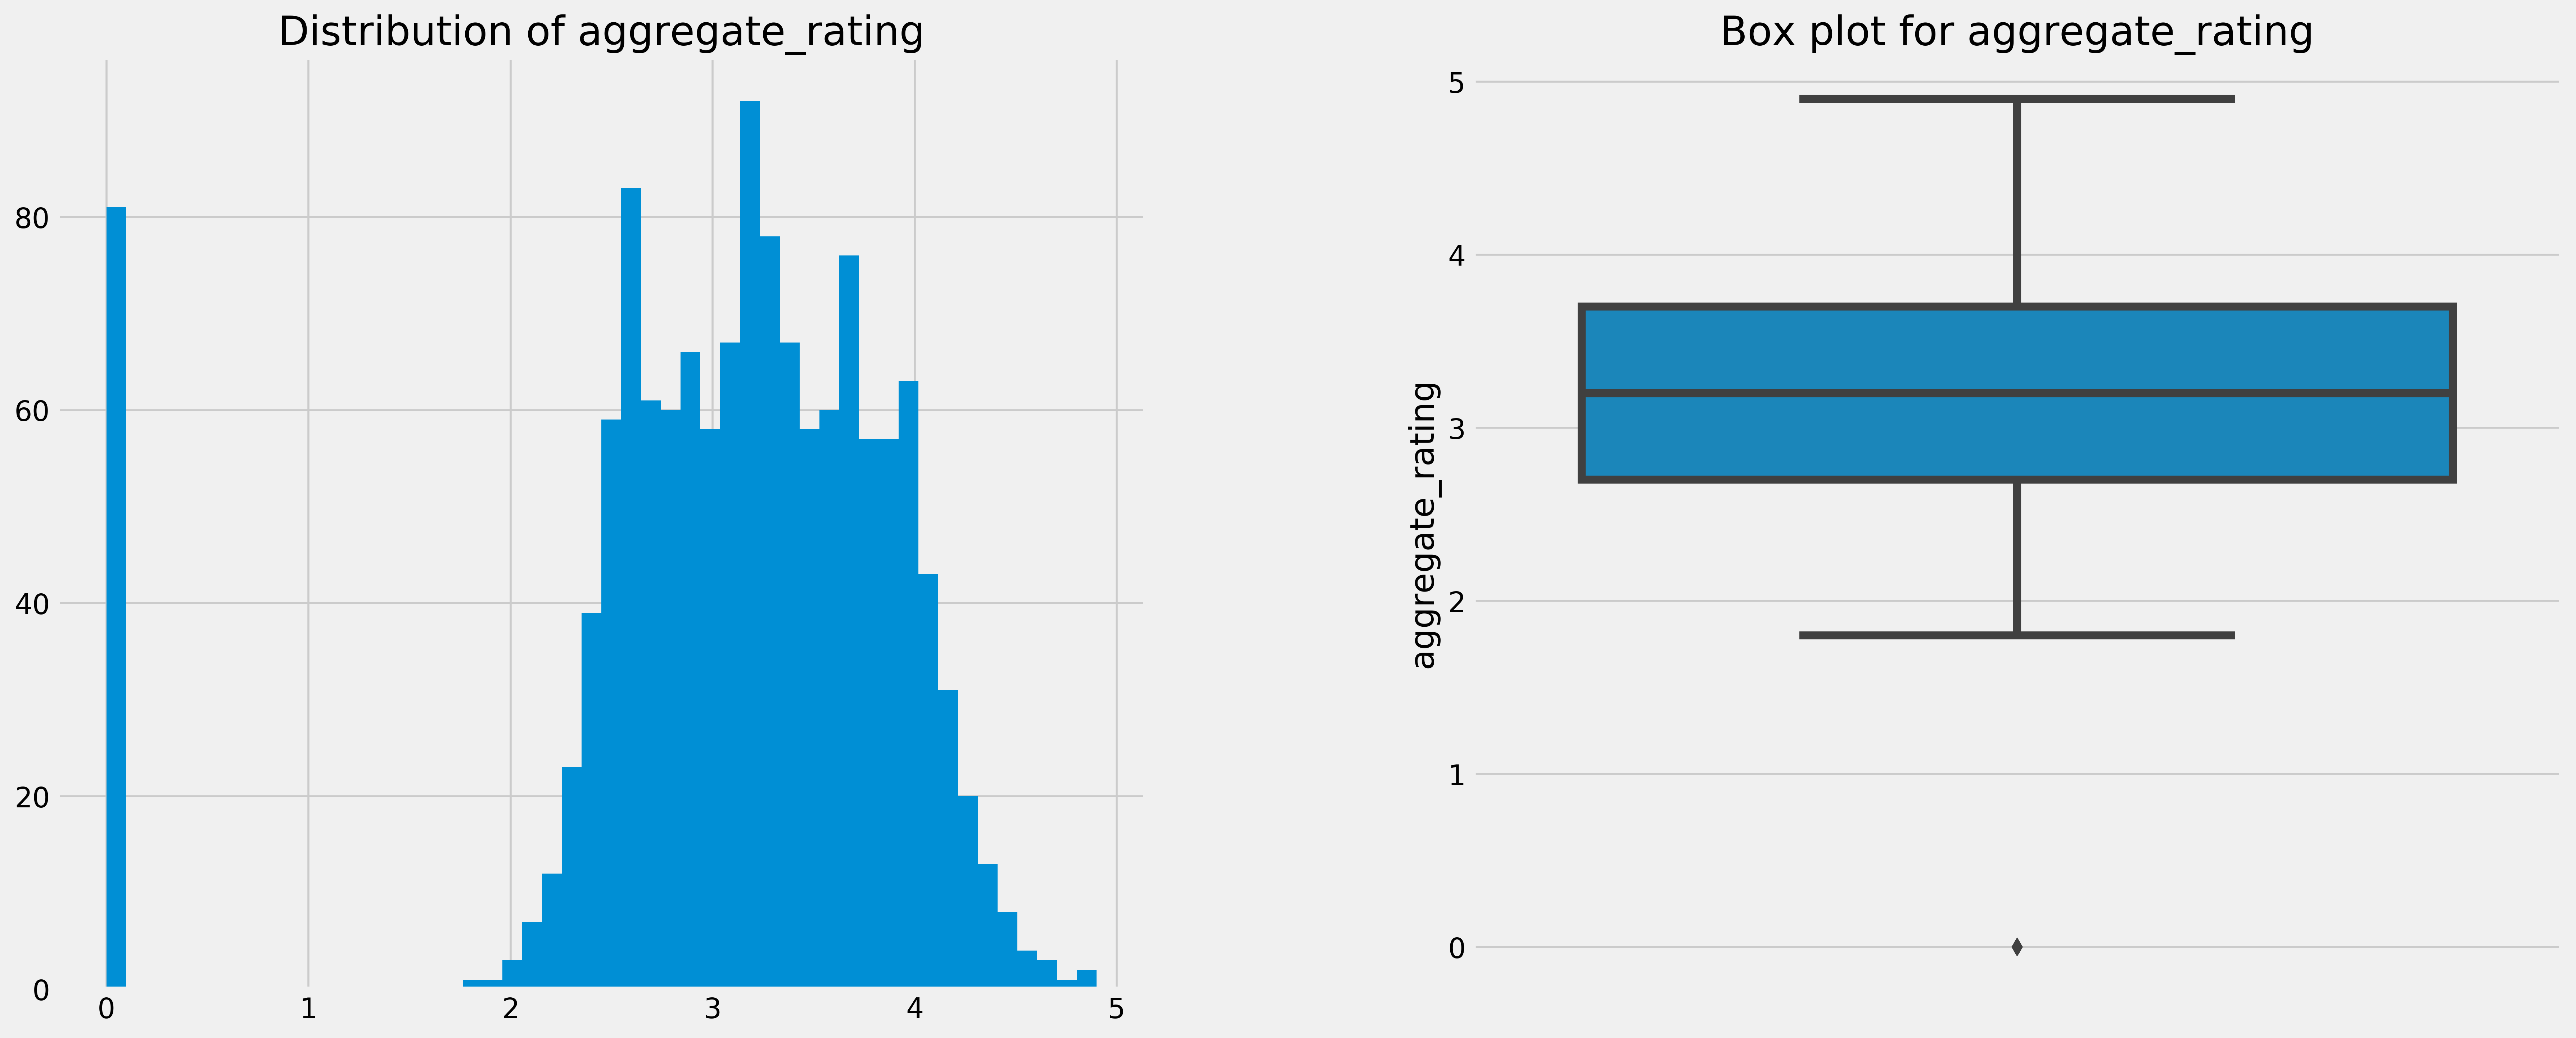

In [60]:
explore_variable(data, "aggregate_rating")

The middle 50% of ratings fall between 2.75 and 3.75 with a median of around 3.25. There are a large number of restaurants with a rating of 0. We should study these further to decide if they should be removed from the analysis or are outliers that carry useful information.

In [61]:
data[data.aggregate_rating == 0]

name  aggregate_rating  \
1273                                    Créme de Levain               0.0   
1274  Kristen's Kick Ass Ice Cream- Noordhoek Farm V...               0.0   
1275                                         Milky Lane               0.0   
1276                                             Smooch               0.0   
1277                     Daniela's Deliciously Decadent               0.0   
1278                                       Filo Yoghurt               0.0   
1279                                             Smooch               0.0   
1280                                      Ice Rock Cafe               0.0   
1281                                     Bonjour Bakery               0.0   
1282                                          Wakaberry               0.0   
1283                                         Sorbetiere               0.0   
1284                          For The Love Of Yummyness               0.0   
1285                                           The Bank               0.0   
1286                                             SoYogi               0.0   
1287                         The Polynesian Pearl Diver               0.0   
1288                           Oh La La Cocktail Lounge               0.0   
1289                                   The Chef’s Bench               0.0   
1290                            Marcel's Frozen Yoghurt               0.0   
1291                                            Mercury               0.0   
1292                                         Club Lenin               0.0   
1293                                            DV Café               0.0   
1294                                      Ice Rock Cafe               0.0   
1295                                           Yogi Bar               0.0   
1296                                           IceDream               0.0   
1297                                             Gelato               0.0   
1298                                     Caldo & Freddo               0.0   
1299                            Marcel's Frozen Yoghurt               0.0   
1300                            Marcel's Frozen Yoghurt               0.0   
1301                            Lili's Ice Cream Parlor               0.0   
1302                                   Club Eighty-Nine               0.0   
...                                                 ...               ...   
1324                                     Burger De Vine               0.0   
1325                                            The Hub               0.0   
1326                                            Wing It               0.0   
1327                                  Eezi Street Pizza               0.0   
1328                                               Sno.               0.0   
1329                                       Healthy Bite               0.0   
1330                       The Biggest Little Beer Shop               0.0   
1331                                Daytona Pub & Venue               0.0   
1332                            Sea Street Bar & Lounge               0.0   
1333                                            GoldBar               0.0   
1334                                            Sky Bar               0.0   
1335                                  Cloof Wine Estate               0.0   
1336                                               Njam               0.0   
1337                                  Fria's Superfoods               0.0   
1338                                         The Pantry               0.0   
1339                                            localli               0.0   
1340                       Sweet Cillie's Cakery & Deli               0.0   
1341                                 Oakhurst Farmstall               0.0   
1342                               At the Village Stall               0.0   
1343                         Everyway Coffee - V&A Mall               0.0   
1344                                      Craft

In [62]:
data[data.aggregate_rating == 0]["locality"].value_counts()

Kenilworth                13
CBD                        9
V & A Waterfront           5
Sea Point                  4
Goodwood                   3
Stellenbosch               3
Woodstock                  3
Hermanus                   3
Noordhoek                  2
Somerset West              2
Brackenfell                2
Zonnebloem                 2
Bellville                  2
Hout Bay                   2
Table View                 2
Neelsie Student Centre     1
Strand                     1
Foreshore                  1
Parklands                  1
De Waterkant               1
Athlone                    1
Diep River                 1
Fish Hoek                  1
Century City               1
Constantia                 1
Observatory                1
Gordon's Bay               1
Malmesbury                 1
Crawford                   1
Green Point                1
Plumstead                  1
Simon's Town               1
Darling                    1
Franschhoek                1
Worcester     

In [63]:
data[data.locality == "Kenilworth"].shape

(37, 89)

Restaurants with very few votes are given a rating of 0. Interestingly, the suburb of Kenilworth has no ratings for 13 of its 37 restaurants.

Let's see how many votes are needed before a rating is registered.

In [64]:
data[(data.aggregate_rating > 0.0) & (data.aggregate_rating < 2)] 

name  aggregate_rating rating_text  votes  average_cost_for_two  \
1271  Mugg & Bean               1.9        Poor     80                   350   
1272         Dros               1.8        Poor     78                   350   

      price_range                                      cuisines  \
1271            4                                          Cafe   
1272            4  South African, Grill, Seafood, Burger, Pizza   

      cuisine_count           places                         locality  \
1271              1             None  Cape Town International Airport   
1272              5  Canal Walk Mall                     Century City   

         ...     Steak Street Food  Sushi  Tapas  Tea  Tex-Mex  Thai  Turkish  \
1271     ...         0           0      0      0    0        0     0        0   
1272     ...         0           0      0      0    0        0     0        0   

      Vegetarian  Vietnamese  
1271           0           0  
1272           0           0  

[2 rows x 89 columns]

There are no restaurants with a rating of 1 or less. This could just be our sample or it could be the way the rating system works. It is unclear how the ratings are assigned but some research suggests that it's weighted based on the influence carried by those who give the rating, i.e. votes from user's with a larger following are more heavily weighted.

Should we exclude restaurants with a zero rating from the analysis? A restaurant with no rating doesn't neccessarily mean it's terrible. Fast food franchises for example are unlikely to get as many people interested in voting for them as fine-dining establishments. Also, foodie influencers are more likely to review and vote on top restaurant than on everyday fast food joints. Restaurant with 0 rating still provide us good info about the type of food in offer in a specific area, but caution must be applied when performing aggegations. It will be considered on a case-by-case basis whether it makes sense for zero-rated restaurants to be kept or removed from analysis.

'average_cost_for_two' is of type int64 with 0 missing values


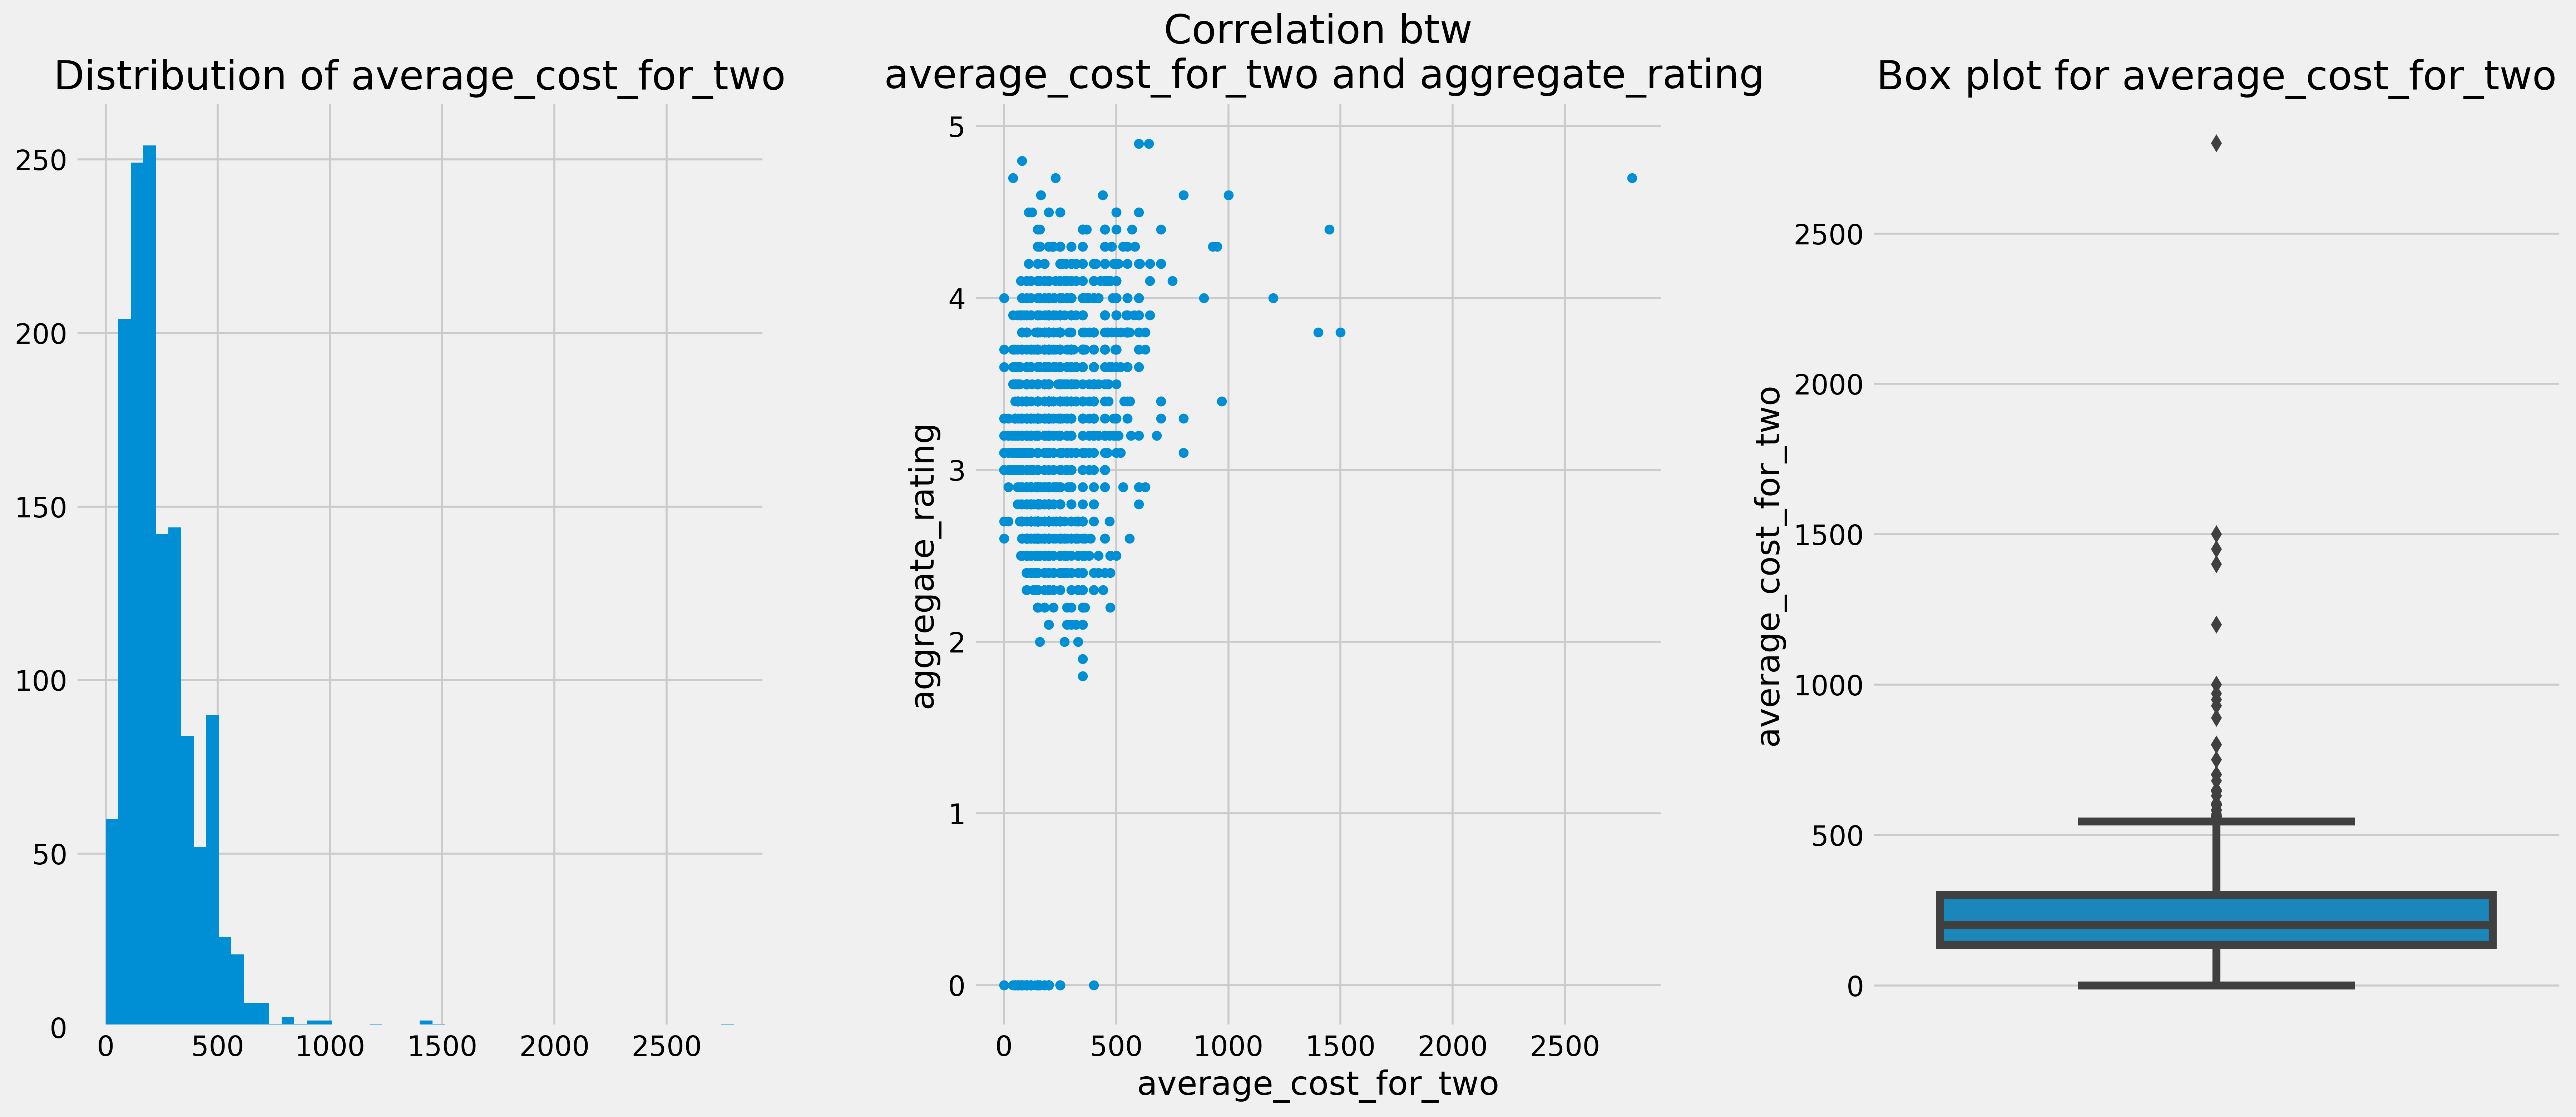

In [65]:
explore_variable(data, "average_cost_for_two", "aggregate_rating")

There isn't much correlation between avg price for two and rating. There are quite a few cost outliers but given that there are many fine-dining restaurants in Cape Town, this shouldn't be a suprise. Let's take a look at some of these.

In [66]:
data[data.average_cost_for_two > 1000]

name  aggregate_rating rating_text  votes  \
4                     The Test Kitchen               4.7   Excellent    242   
30   Greenhouse - The Cellars Hohenort               4.4   Very Good     83   
141                      Rust en Vrede               4.0   Very Good     50   
263               Reverie Social Table               3.8        Good     24   
273                     The Roundhouse               3.8        Good     68   

     average_cost_for_two  price_range  \
4                    2800            4   
30                   1450            4   
141                  1200            4   
263                  1400            4   
273                  1500            4   

                                       cuisines  cuisine_count  \
4                         Continental, European              2   
30                                     European              1   
141                                     African              1   
263  South African, International, Contemporary              3   
273                           European, African              2   

                    places      locality     ...     Steak Street Food  Sushi  \
4         Old Biscuit Mill     Woodstock     ...         0           0      0   
30   The Cellars-Hohenhort    Constantia     ...         0           0      0   
141                   None  Stellenbosch     ...         0           0      0   
263                   None   Observatory     ...         0           0      0   
273                   None     Camps Bay     ...         0           0      0   

     Tapas  Tea  Tex-Mex  Thai  Turkish  Vegetarian  Vietnamese  
4        0    0        0     0        0           0           0  
30       0    0        0     0        0           0           0  
141      0    0        0     0        0           0           0  
263      0    0        0     0        0           0           0  
273      0    0        0     0        0           0           0  

[5 rows x 89 columns]

As expected, these are well-known top end restaurants in Cape Town. Their values may skew the mean so we should be cautious when including them in any analysis. Let's see if the top end restaurants (in terms of avg. cost) tend to come from certain suburbs.

In [67]:
data[data.average_cost_for_two >= 800]["locality"].value_counts()

Constantia          3
V & A Waterfront    2
Paarl               2
Observatory         1
Hermanus            1
Camps Bay           1
Stellenbosch        1
Woodstock           1
Gardens             1
Name: locality, dtype: int64

Let's get a sense of how the restaurants on the low end of pricing are distributed geographically.

In [68]:
data[data.average_cost_for_two <= 200]["locality"].value_counts()

CBD                                72
Stellenbosch                       62
V & A Waterfront                   38
Sea Point                          36
Bellville                          30
Claremont                          29
Kenilworth                         28
Century City                       24
Durbanville                        22
Franschhoek                        20
Table View                         19
Gardens                            18
Somerset West                      17
Observatory                        16
Green Point                        16
Paarl                              16
Woodstock                          15
Brackenfell                        15
Rondebosch                         14
De Waterkant                       14
Goodwood                           12
Hout Bay                           11
Hermanus                           11
Newlands                            9
Constantia                          8
Parklands                           8
Foreshore   

There are also many establishments that define themselves as `Drinks Only` - bars, cocktail lounges etc. We might want to create a sepersate dataset for these and/or exclude them from analysis in some instances.

In [69]:
data[data["cuisines"] == "Drinks Only"]

name  aggregate_rating  \
44                                         The Gin Bar               4.3   
97                               Fairview Tasting Room               4.1   
120                                         Boschendal               4.1   
180                             Steenberg Tasting Room               4.0   
181                              Waterford Wine Estate               4.0   
201                            Groot Constantia Winery               3.9   
223                      Tasting Room at Babylonstoren               3.9   
225                             Vergenoegd Wine Estate               3.9   
237                           Spice Route Tasting Room               3.9   
240             Van Ryn's Distillery and Brandy cellar               3.9   
248                          Rupert & Rothschild Wines               3.8   
310                                     Arra Vineyards               3.7   
325                                 Spier Wine Tasting               3.7   
331                               Vrede en Lust Winery               3.7   
364                                            Cabrito               3.7   
371                            Mother's Ruin - Gin Bar               3.7   
372                                  Peter Falke Wines               3.7   
376                                   The Silo Rooftop               3.7   
396                              Rickety Bridge Winery               3.6   
397                            Lourensford Wine Estate               3.6   
432                                    Ernie Els Wines               3.6   
448                               Delheim Tasting Room               3.5   
465                               Cavalli Tasting Room               3.5   
466                          Delaire Graff Wine Lounge               3.5   
468                          Altydgedacht Tasting Room               3.5   
470                                         Deco Dance               3.5   
506   Anthonij Rupert Tasting Room @ L'Ormarins Estate               3.4   
507                             Hillcrest Tasting Room               3.4   
531                           Van Loveren Tasting Room               3.4   
544                        Harringtons Cocktail Lounge               3.4   
...                                                ...               ...   
961                                      Pig & Swizzle               2.8   
963                                           Bang Bar               2.8   
971                                     Hanover Street               2.8   
972                                           Crew Bar               2.8   
976                                 Banned Rock Lounge               2.8   
978                               Newton Johnson Wines               2.8   
979                                        Casa Nostra               2.8   
1013                           Two And Sixpence Tavern               2.7   
1018                                            Abantu               2.7   
1020                                       The Crowbar               2.7   
1028                                           Jo'burg               2.7   
1058                                           Zevolis               2.6   
1136                                       The Cue Inn               2.5   
1137                                            Stones               2.5   
1194                                          Tin Roof               2.4   
1285                                          The Bank               0.0   
1287                        The Polynesian Pearl Diver               0.0   
1288                          Oh La La Cocktail Lounge               0.0   
1291                                           Mercury               0.0   
1292                                        Club Lenin               0.0   
1302                                  Club Eighty-Nine               0.0   
1306                  

'price_range' is of type int64 with 0 missing values


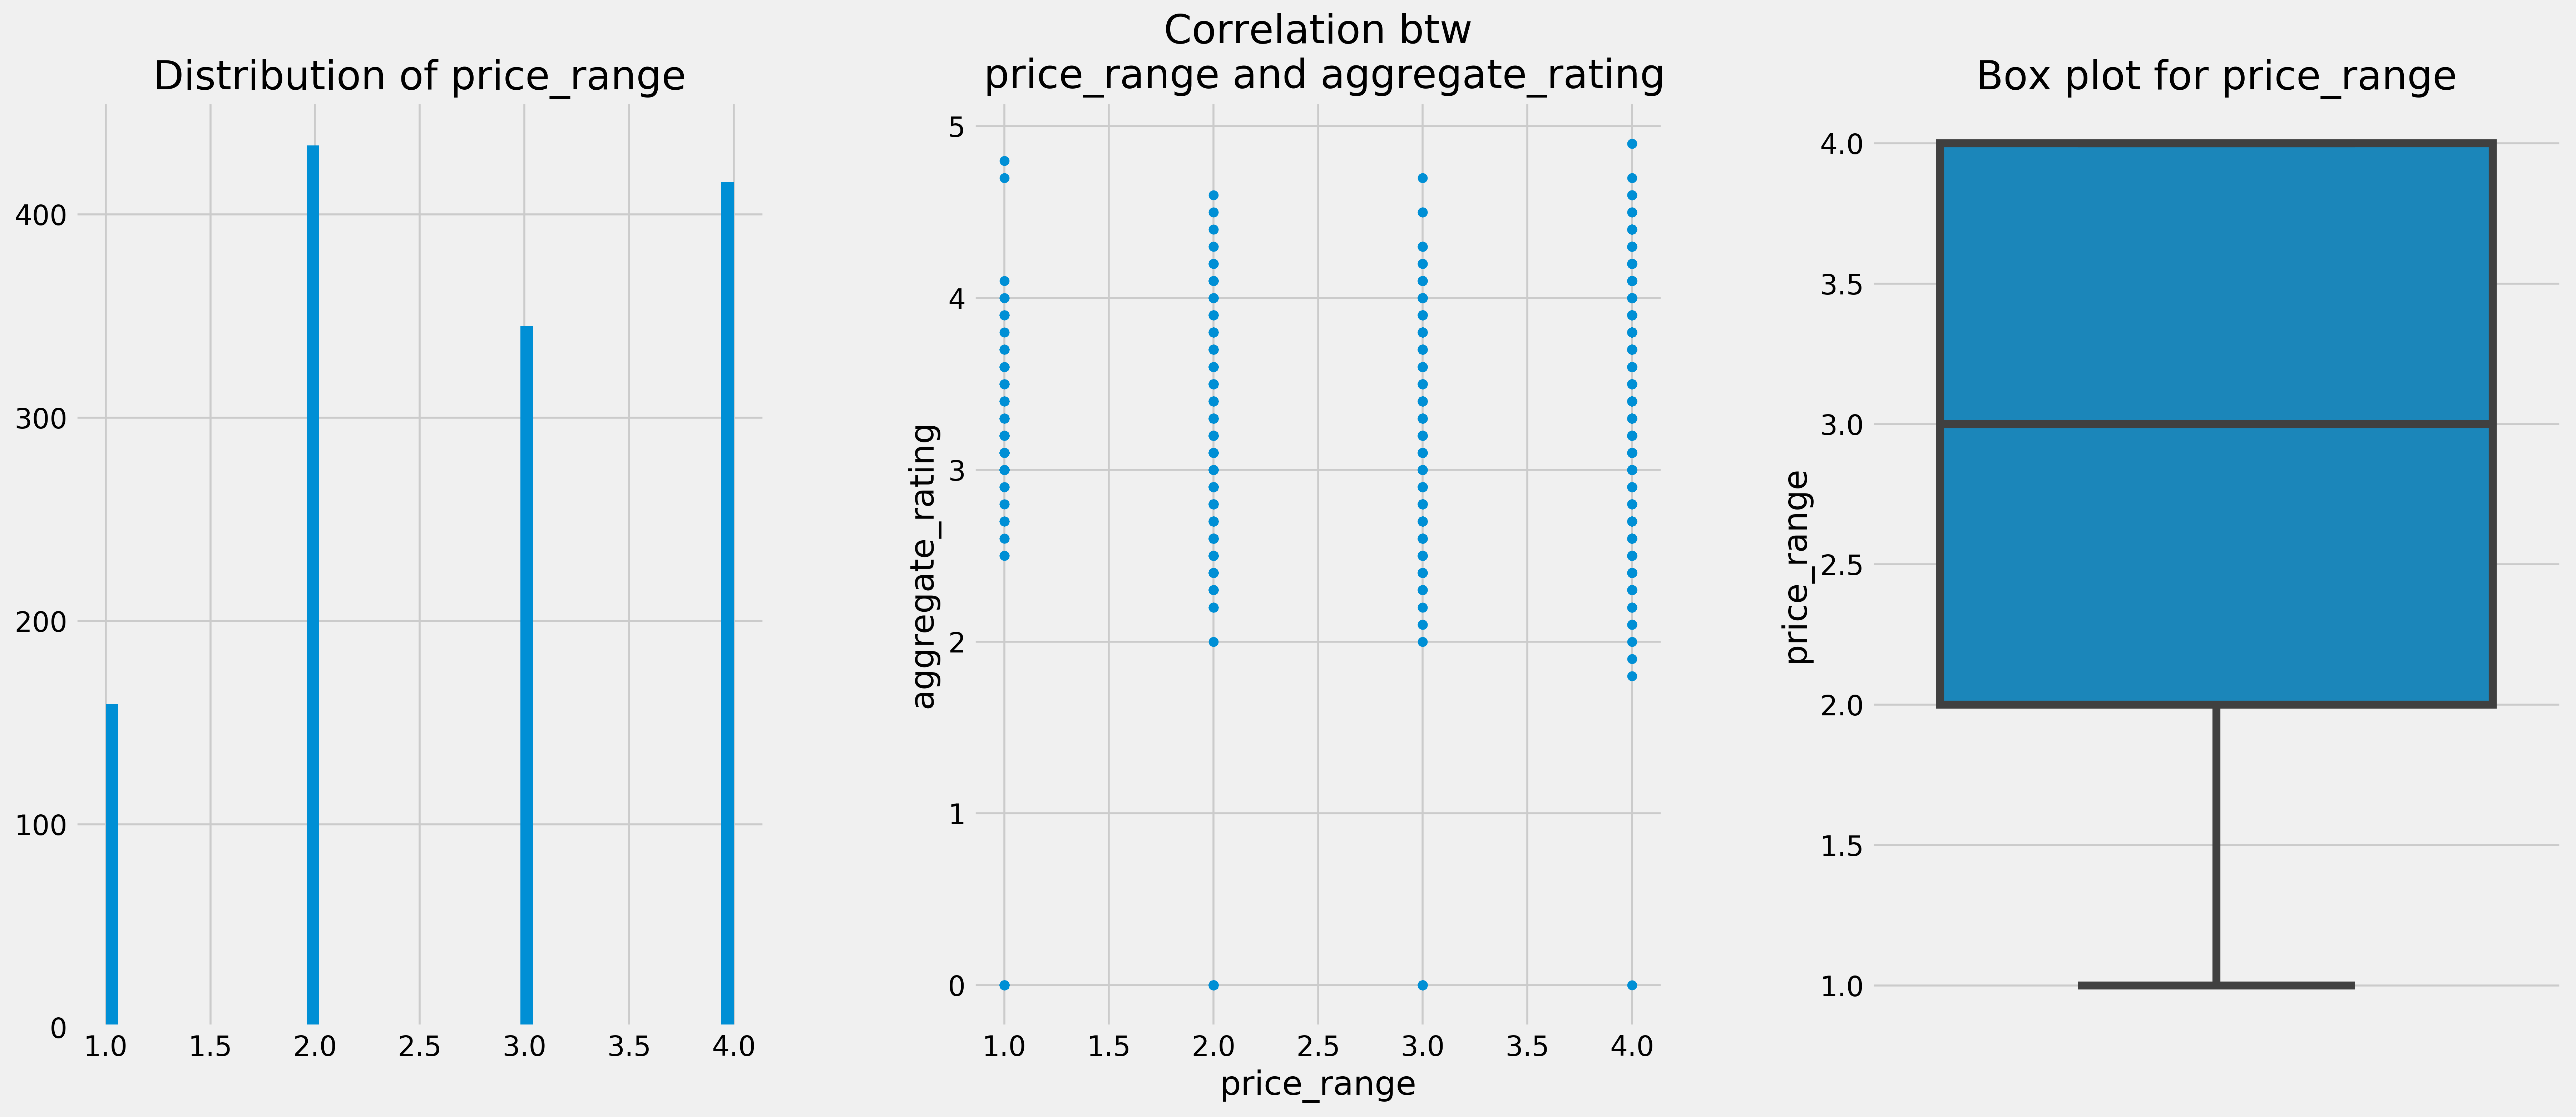

In [70]:
explore_variable(data, "price_range", "aggregate_rating")

Closely related to average price for two is the `price_range` variable assigned by Zomato. This is a 1 - 4 scale and we can see that the majority of restaurants are in price range 2 and 4. Let's see what the median cost per two is for each of those ranges. We'll look at median instead of mean as we know that some top-end restarants will skew price range 4. 

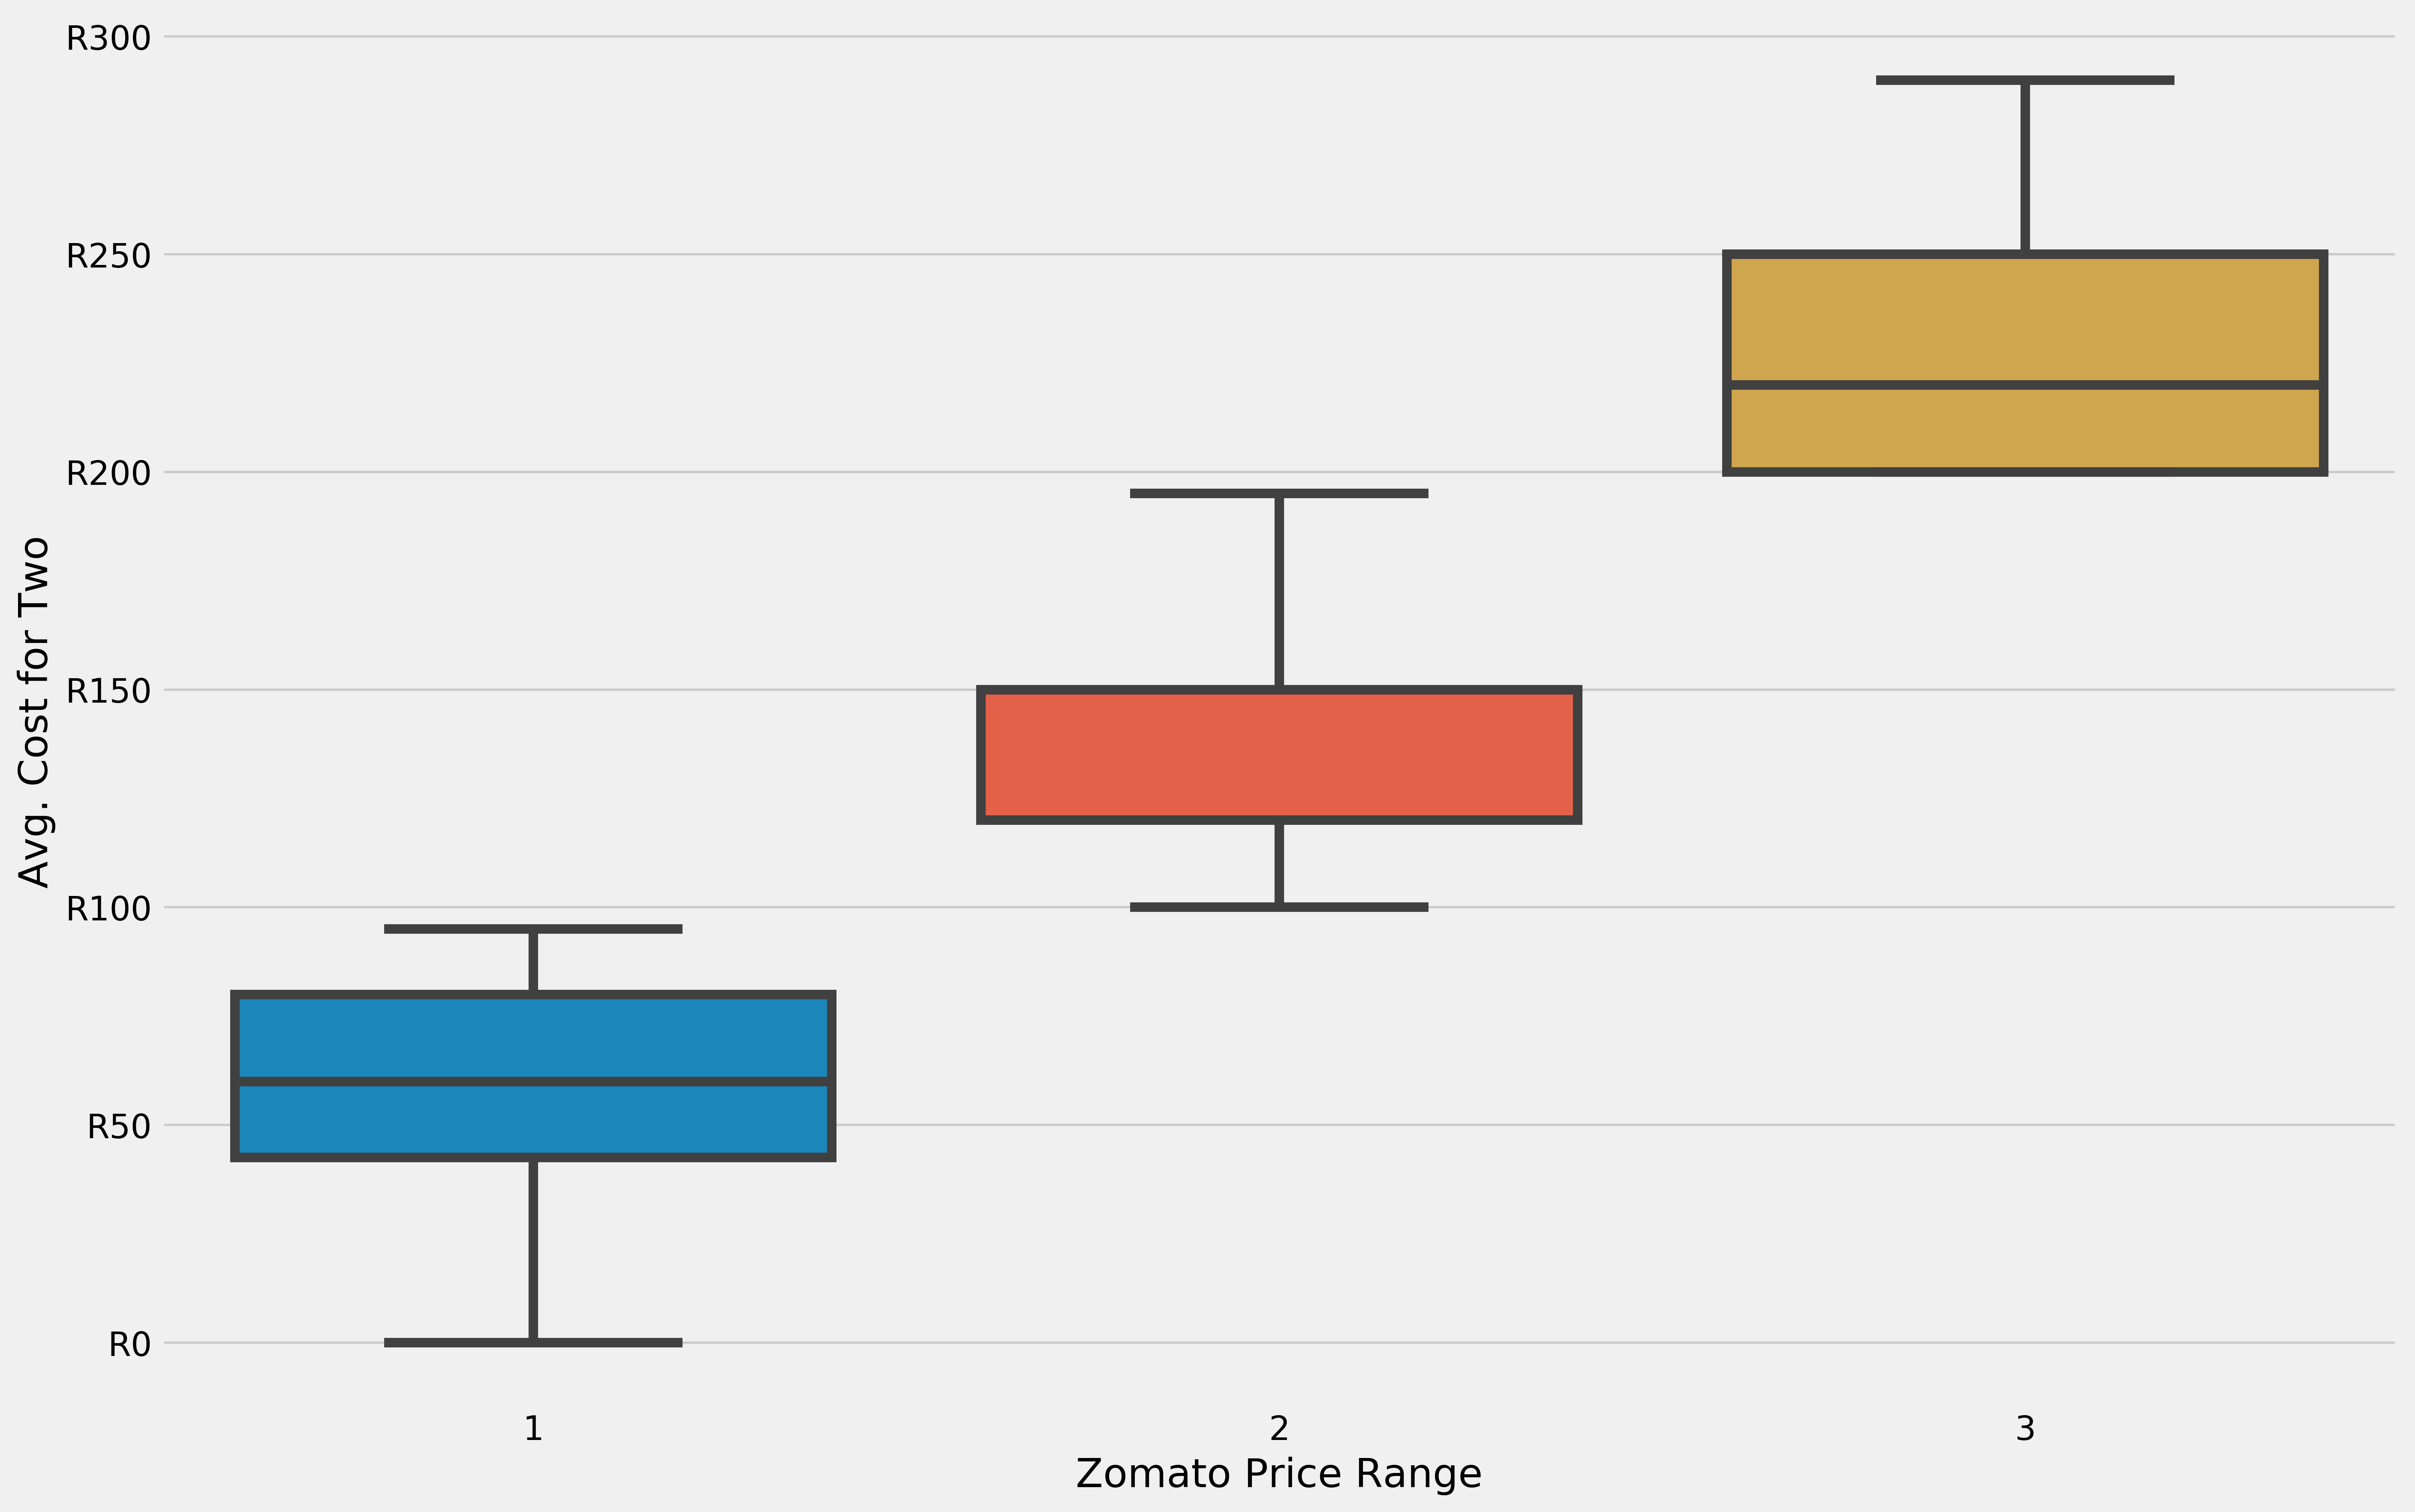

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=400)
ax = sns.boxplot(x="price_range", y="average_cost_for_two", data=data[data.price_range <= 3])
ax.set_ylabel("Avg. Cost for Two")
ax.set_xlabel("Zomato Price Range")
ax.yaxis.set_major_formatter(axes_formatter)

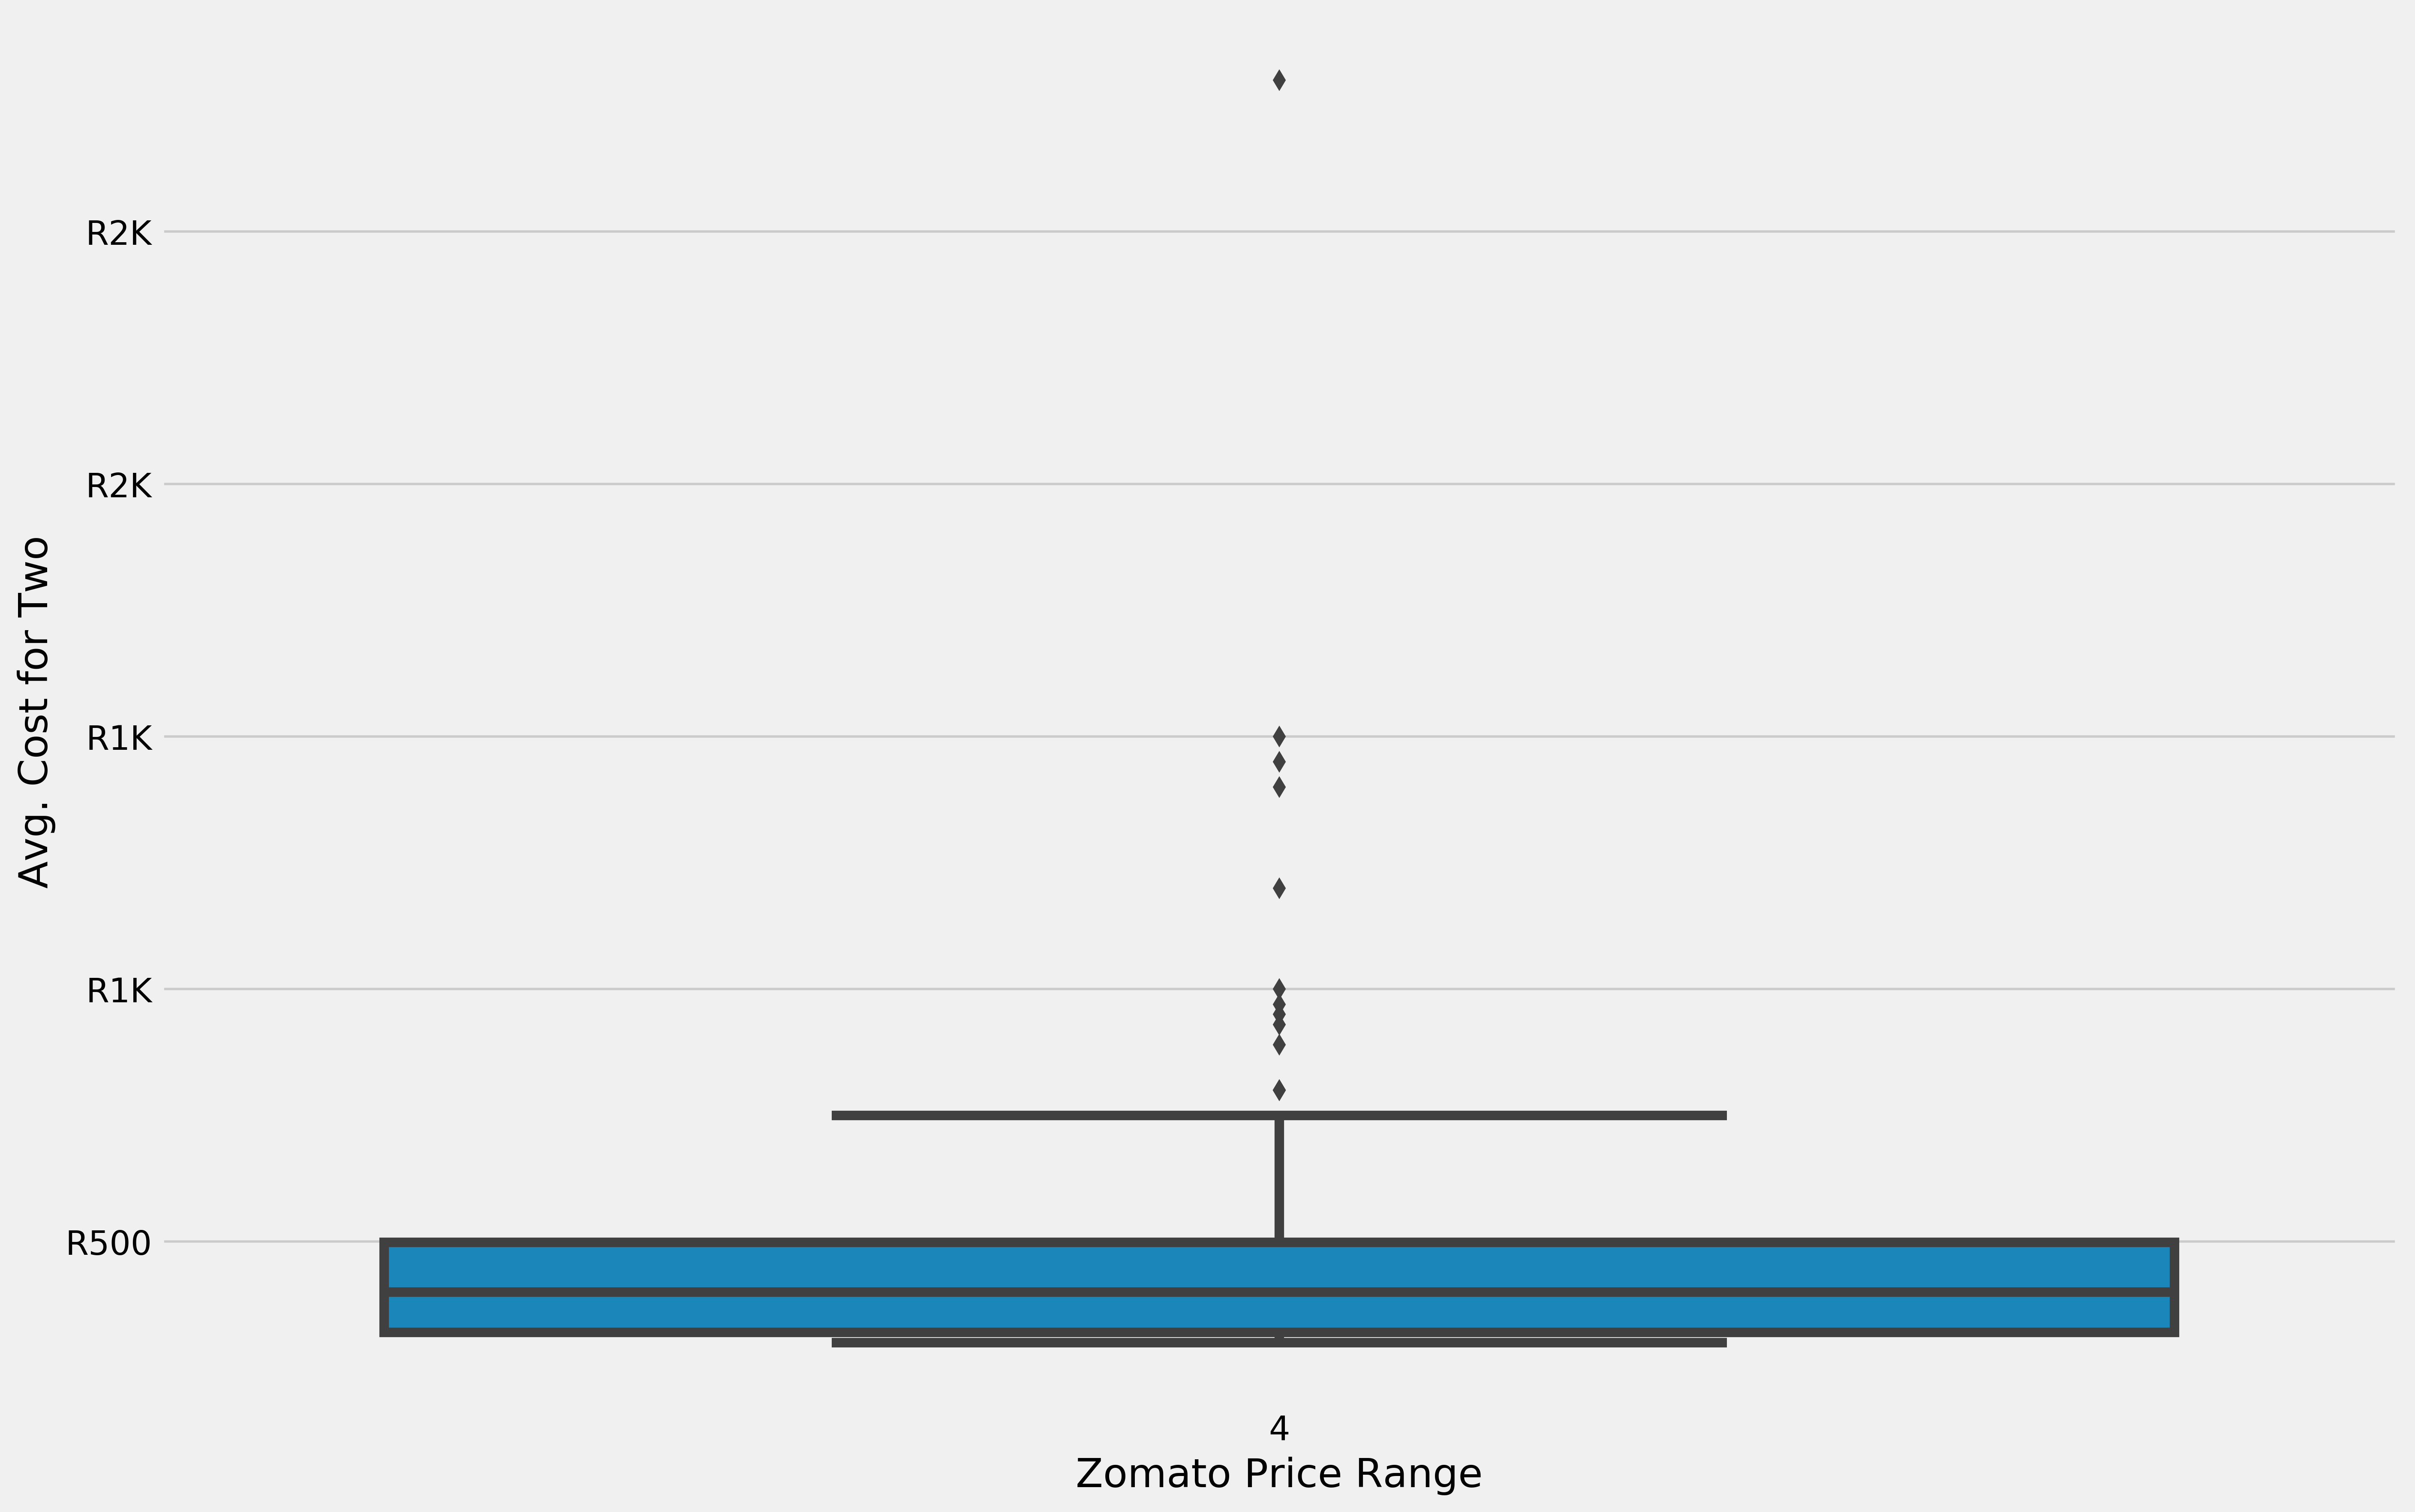

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=400)
ax = sns.boxplot(x="price_range", y="average_cost_for_two", data=data[data.price_range > 3])
ax.set_ylabel("Avg. Cost for Two")
ax.set_xlabel("Zomato Price Range")
ax.yaxis.set_major_formatter(axes_formatter)

Once again let's consider the mean values for rating, vote count and total number of cuisines on offer per price range.

Text(0.5,0.98,'Avg. Rating, Votes & No. Cuisines by Price Range')

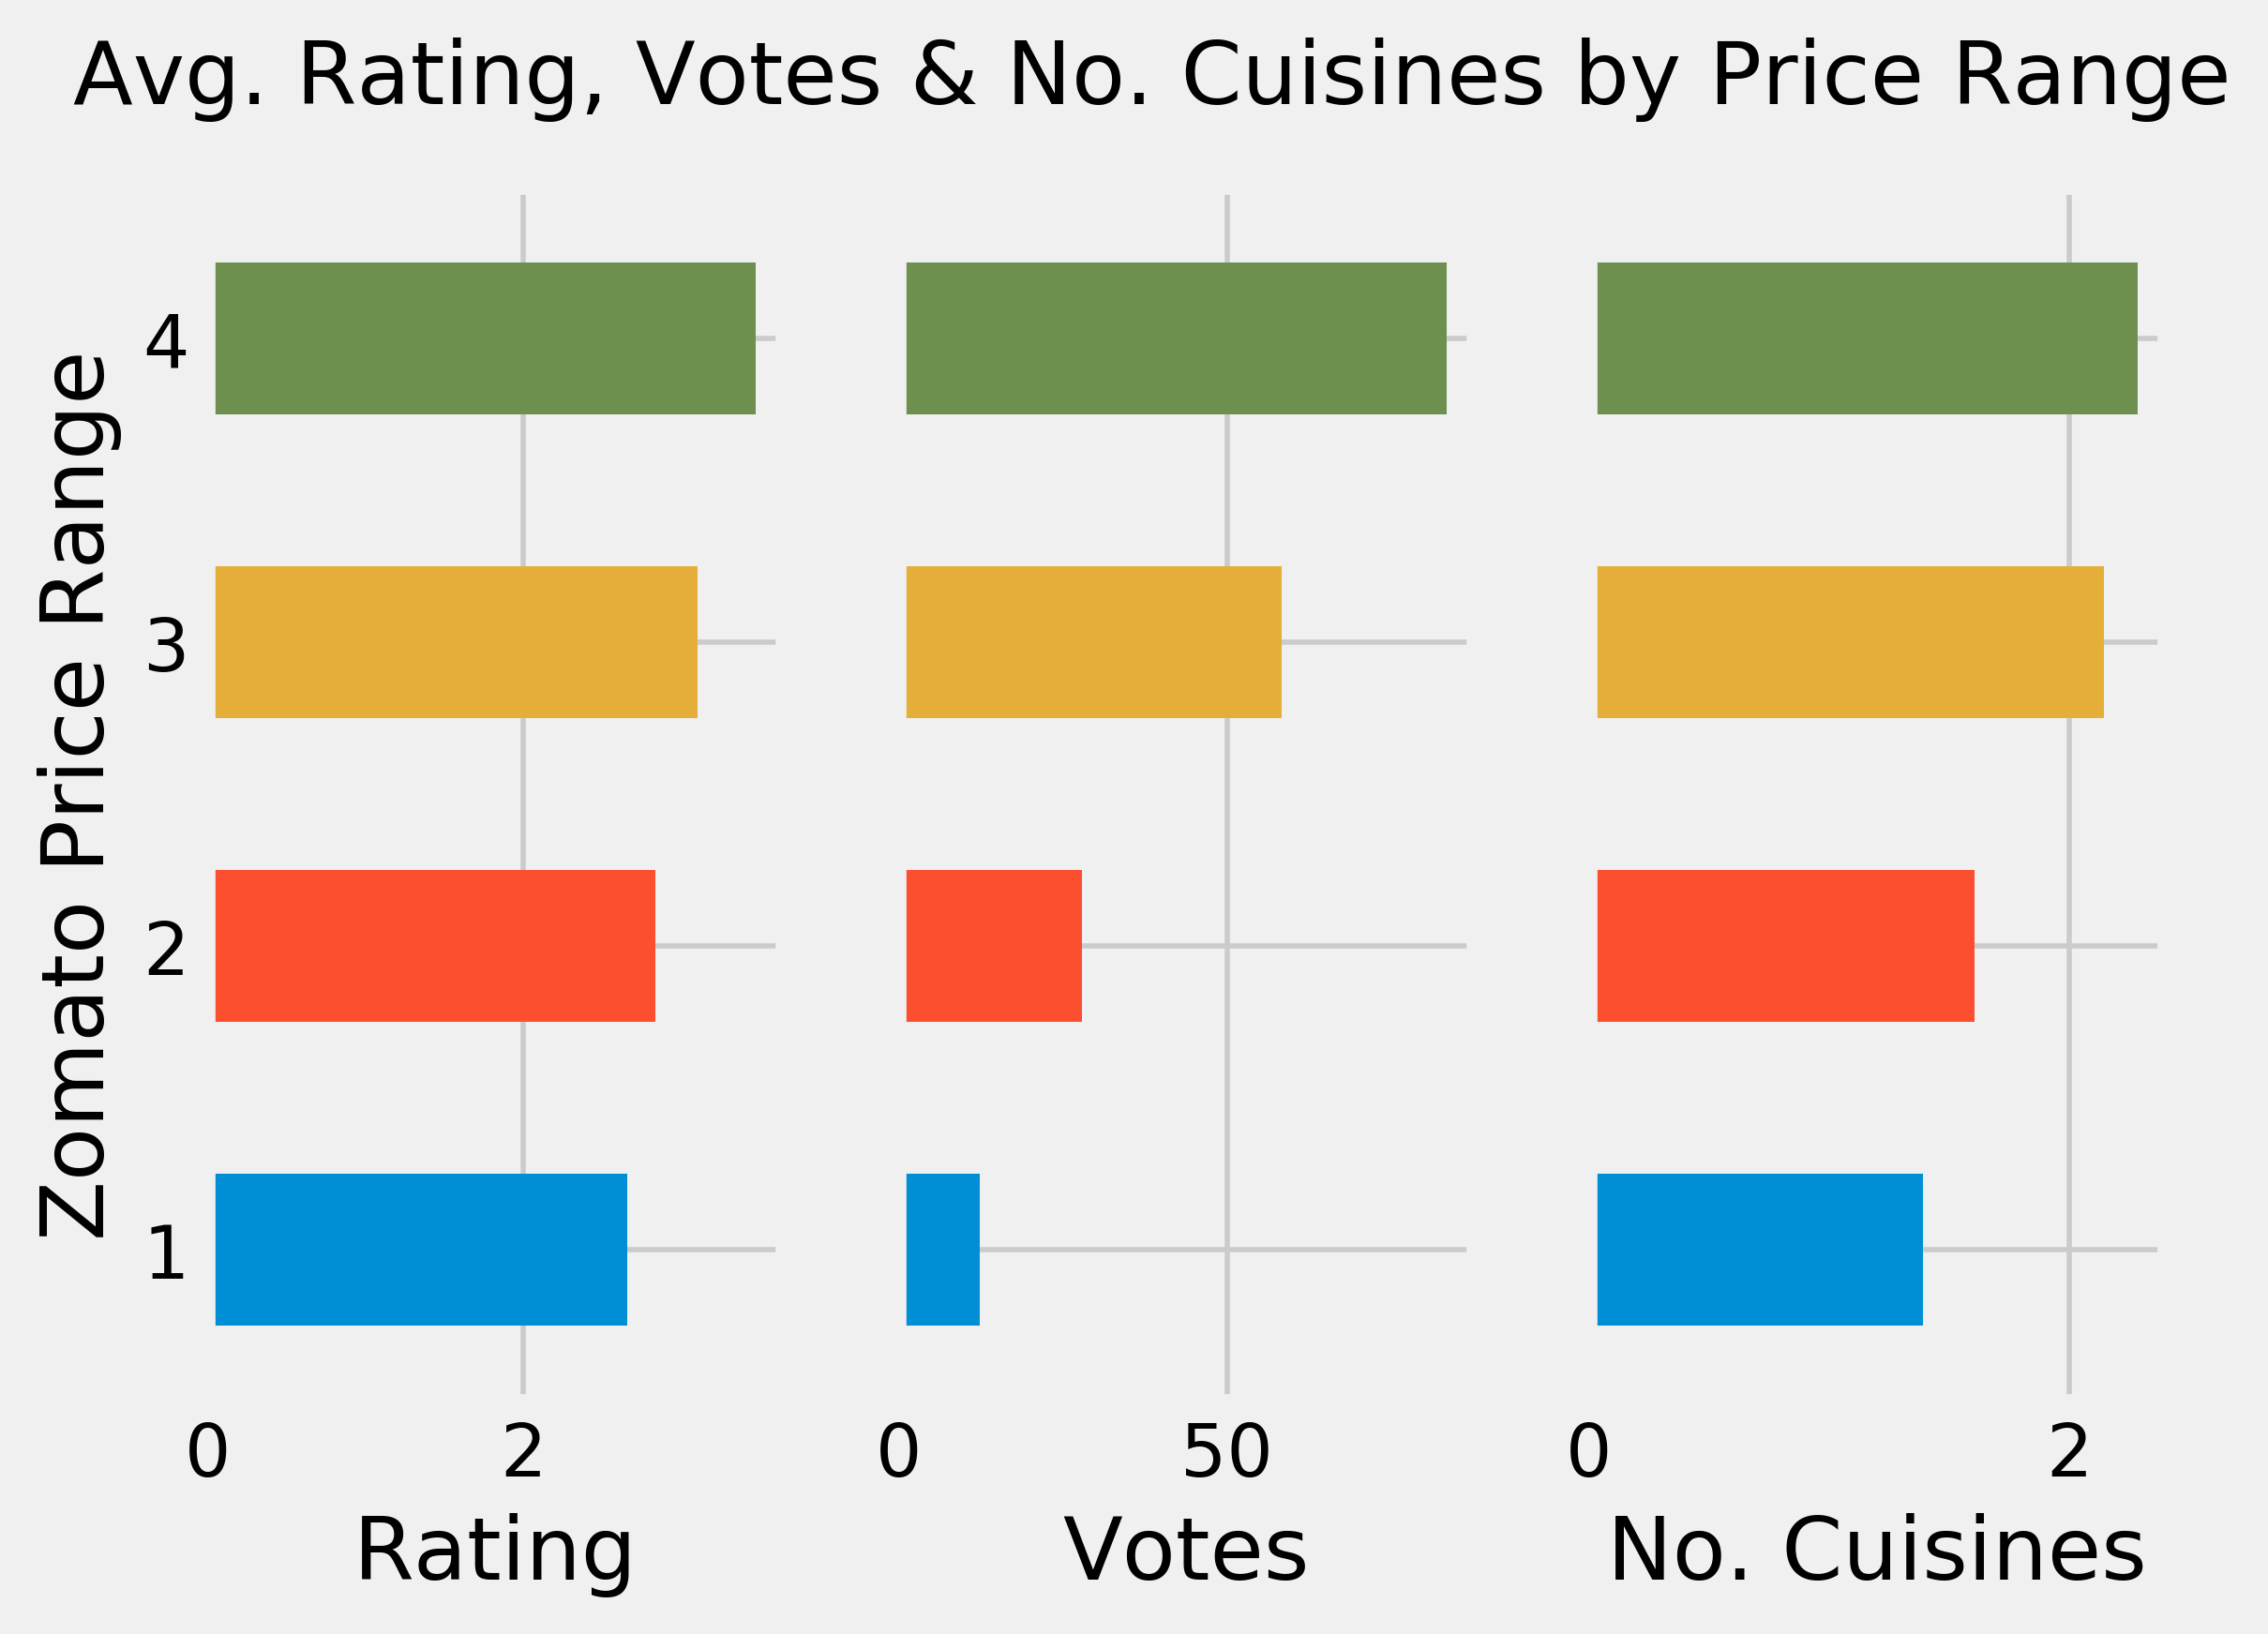

In [73]:
df = data.pivot_table(index="price_range", aggfunc="mean")

cols = ["aggregate_rating", "votes", "cuisine_count"]
xlabels = ["Rating", "Votes", "No. Cuisines"]
fig, ax = plt.subplots(1, 3, sharey='row', dpi=400)
#fig.subplots_adjust(hspace=0.4)

for ax, col, xlabel in zip(ax.ravel(), cols, xlabels):
    df[col].plot.barh(ax=ax)
    ax.set_xlabel(xlabel)
    if col == "average_cost_for_two":
        ax.xaxis.set_major_formatter(axes_formatter)
    ax.set_ylabel("Zomato Price Range")
   
plt.suptitle("Avg. Rating, Votes & No. Cuisines by Price Range")
#save_fig('investment-multiple-years-risks-lump-sum-monthly-contrib')

The lower the price range, the lower the avgerage rating and average number of votes.

'votes' is of type int64 with 0 missing values


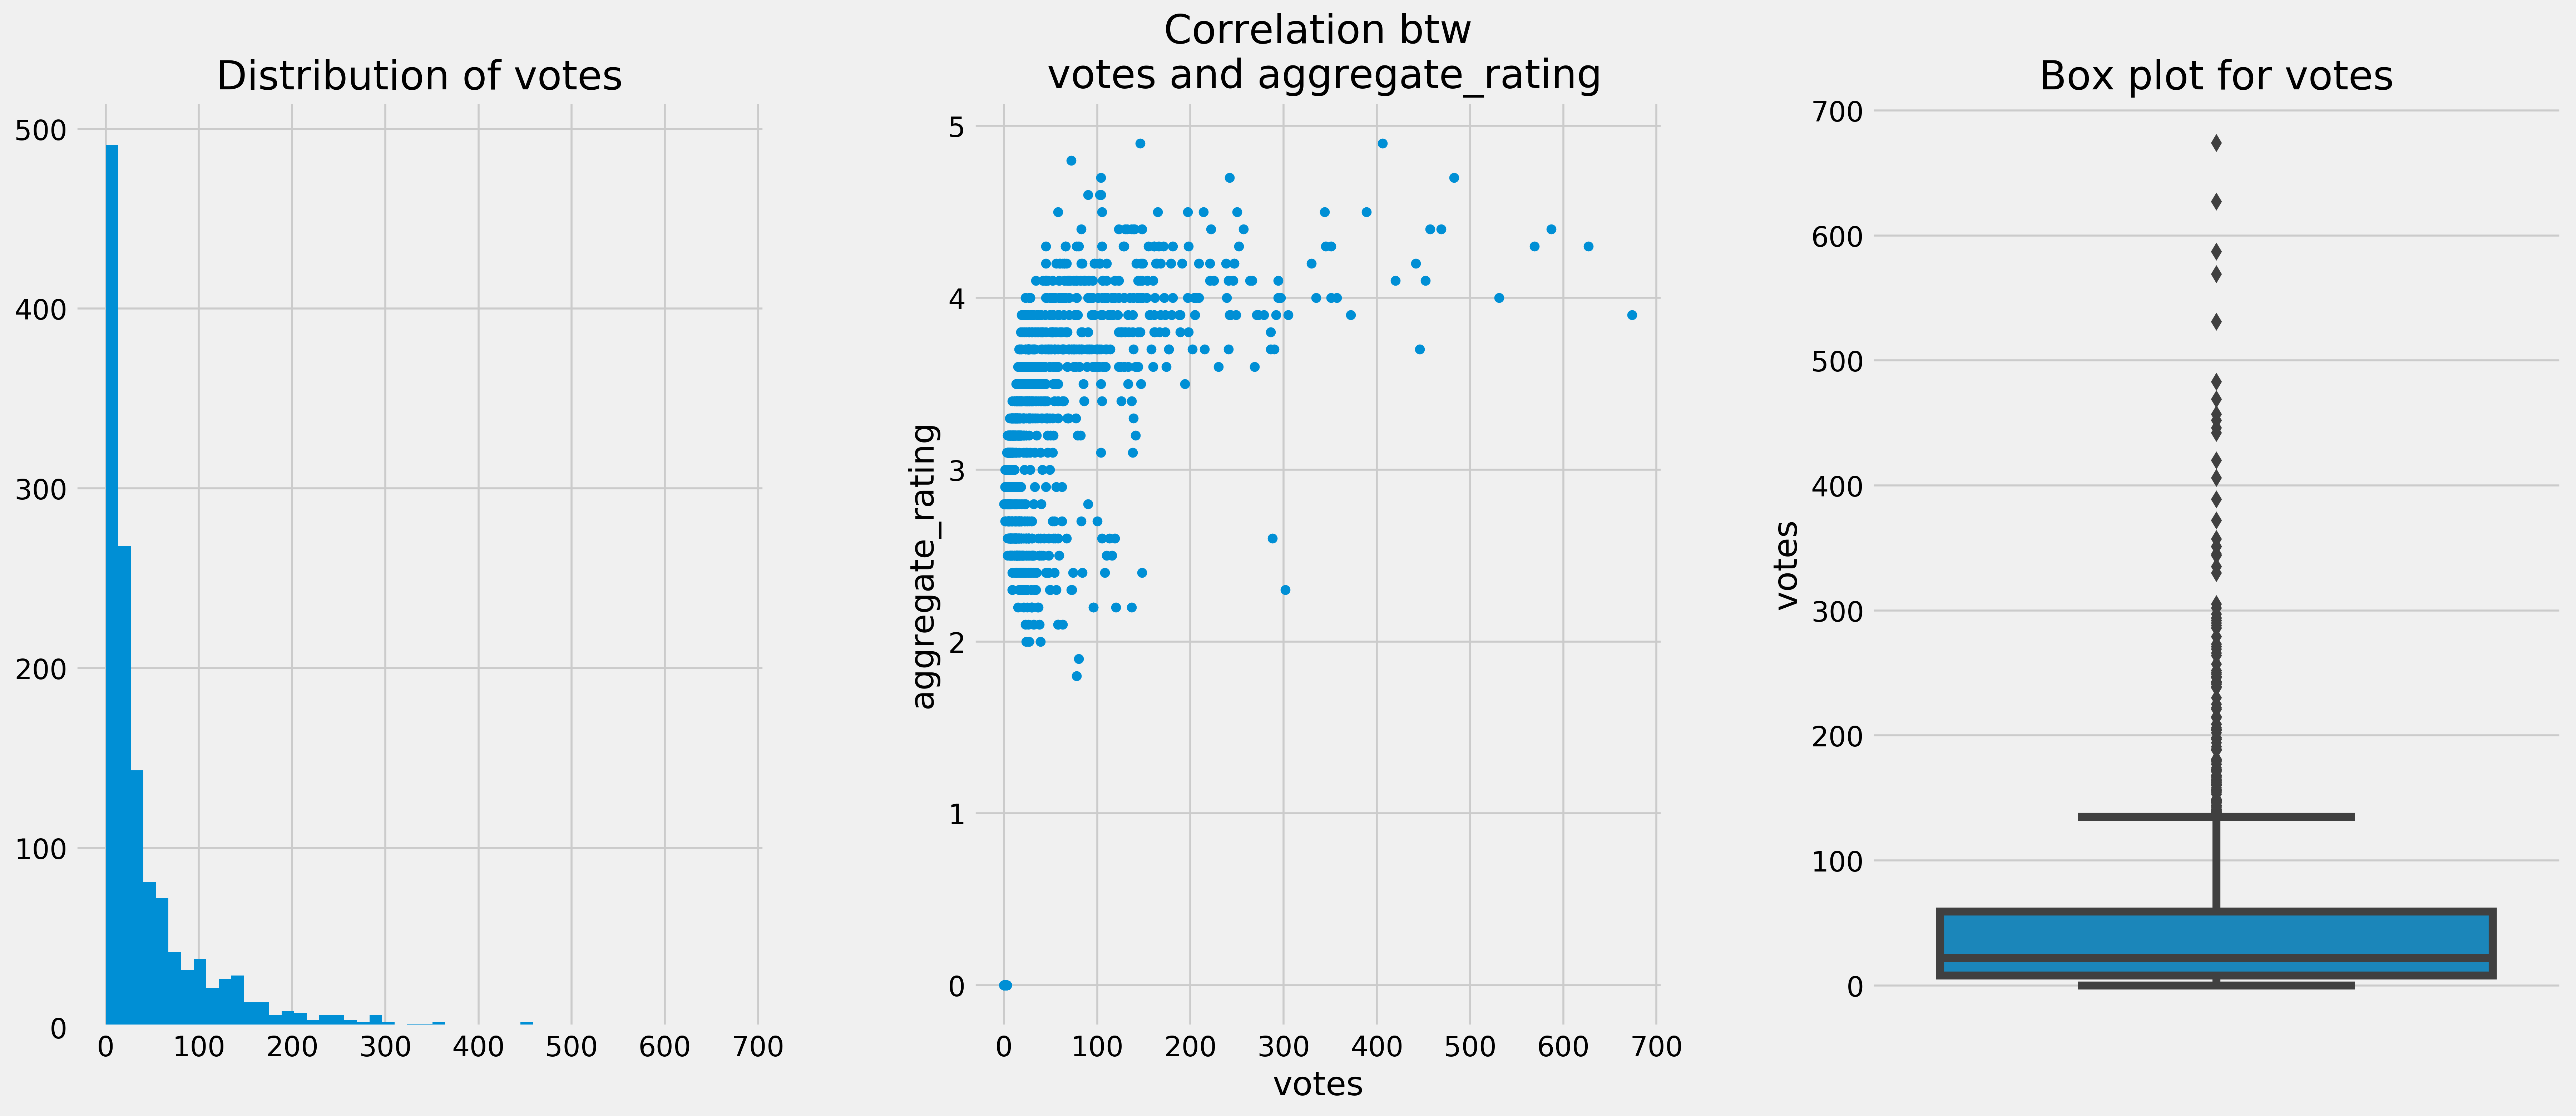

In [74]:
explore_variable(data, "votes", "aggregate_rating")

The majority of restaurnts have less than 200 votes with higher vote counts being provided for the restaurants that earn a higher rating. It's possible that people are more interested to vote on the higher-end restaurants and then due to Zomato's rating system, there is a non-linear relationship between the influence carried by those who do vote based on their community influence.

Let's study the restaurants with the most votes.

In [75]:
data[data.votes >= 200]

name  aggregate_rating rating_text  votes  \
0                      The Potluck Club               4.9   Excellent    406   
4                      The Test Kitchen               4.7   Excellent    242   
5                               Jarryds               4.7   Excellent    483   
11                           La Mouette               4.5   Excellent    250   
12                     Bistro Sixteen82               4.5   Excellent    214   
16                         The Creamery               4.5   Excellent    389   
17                        Four & Twenty               4.5   Excellent    344   
18                   Kloof Street House               4.4   Very Good    469   
19                              Pigalle               4.4   Very Good    257   
26                             El Burro               4.4   Very Good    457   
27                     Willoughby & Co.               4.4   Very Good    587   
28                     Burger & Lobster               4.4   Very Good    222   
38                       Starlings Cafe               4.3   Very Good    351   
41                   Jerry's Burger Bar               4.3   Very Good    345   
42                        Royale Eatery               4.3   Very Good    569   
43                Honest Chocolate Cafe               4.3   Very Good    252   
45                         Truth Coffee               4.3   Very Good    627   
52                               tashas               4.2   Very Good    209   
62                              Woodies               4.2   Very Good    247   
64                             Il Leone               4.2   Very Good    247   
65                                NV 80               4.2   Very Good    221   
75                               tashas               4.2   Very Good    442   
77                         Jason Bakery               4.2   Very Good    330   
79                        Bacon on Bree               4.2   Very Good    238   
82                            La Boheme               4.1   Very Good    294   
100                  Nuri Sushi Factory               4.1   Very Good    452   
101                              tashas               4.1   Very Good    221   
102                      The Fat Cactus               4.1   Very Good    420   
104                               Bocca               4.1   Very Good    225   
106                       Cafe Paradiso               4.1   Very Good    264   
...                                 ...               ...         ...    ...   
144   IYO Burgers (Inside & You're Out)               4.0   Very Good    351   
145                             Salushi               4.0   Very Good    294   
146                   The Village Idiot               4.0   Very Good    239   
152              Origin Coffee Roasting               4.0   Very Good    209   
164                  Da Vincis On Kloof               4.0   Very Good    357   
165          Clarke's Bar & Dining Room               4.0   Very Good    297   
166                            Pancho's               4.0   Very Good    335   
196                         Yours Truly               3.9        Good    205   
206                             Lefty's               3.9        Good    249   
207          The Dog's Bollocks at YARD               3.9        Good    292   
208     Gibson's Gourmet Burgers & Ribs               3.9        Good    372   
209                     Banana Jam Cafe               3.9        Good    243   
210                            Balducci               3.9        Good    242   
211               Rick's Cafe Americain               3.9        Good    273   
215                   Beerhouse on Long               3.9        Good    305   
221                 Bombay Bicycle Club               3.9        Good    279   
226                         The Taproom               3.9        Good    271   
232                              Beluga               3.9        Good    674   
234                        The Bung

What I find interesting is not the restaurants that get top ratings with lots of votes, but rather the restaurants that get good, average or poor ratings with lots of votes. This tells us a lot, far more than restaurants with low ratings that have near zero votes.

# Trend Analysis

In [2]:
data = pd.read_csv('processed/zomato-cape-town-final.csv', encoding='utf-8-sig')
data.head()

name  aggregate_rating rating_text  votes  \
0    The Potluck Club               4.9   Excellent    406   
1          La Colombe               4.9   Excellent    146   
2         Moro Gelato               4.8   Excellent     72   
3  Unframed Ice Cream               4.7   Excellent    104   
4    The Test Kitchen               4.7   Excellent    242   

   average_cost_for_two  price_range                cuisines  cuisine_count  \
0                   600            4  European, Contemporary              2   
1                   645            4           French, Asian              2   
2                    80            1     Desserts, Ice Cream              2   
3                    40            1               Ice Cream              1   
4                  2800            4   Continental, European              2   

             places    locality     ...     Steak Street Food  Sushi  Tapas  \
0  Old Biscuit Mill   Woodstock     ...         0           0      0      0   
1              None  Constantia     ...         0           0      0      0   
2              None         CBD     ...         0           0      0      0   
3              None     Gardens     ...         0           0      0      0   
4  Old Biscuit Mill   Woodstock     ...         0           0      0      0   

   Tea  Tex-Mex  Thai  Turkish  Vegetarian  Vietnamese  
0    0        0     0        0           0           0  
1    0        0     0        0           0           0  
2    0        0     0        0           0           0  
3    0        0     0        0           0           0  
4    0        0     0        0           0           0  

[5 rows x 89 columns]

## Restaurant Count by Region and Suburb

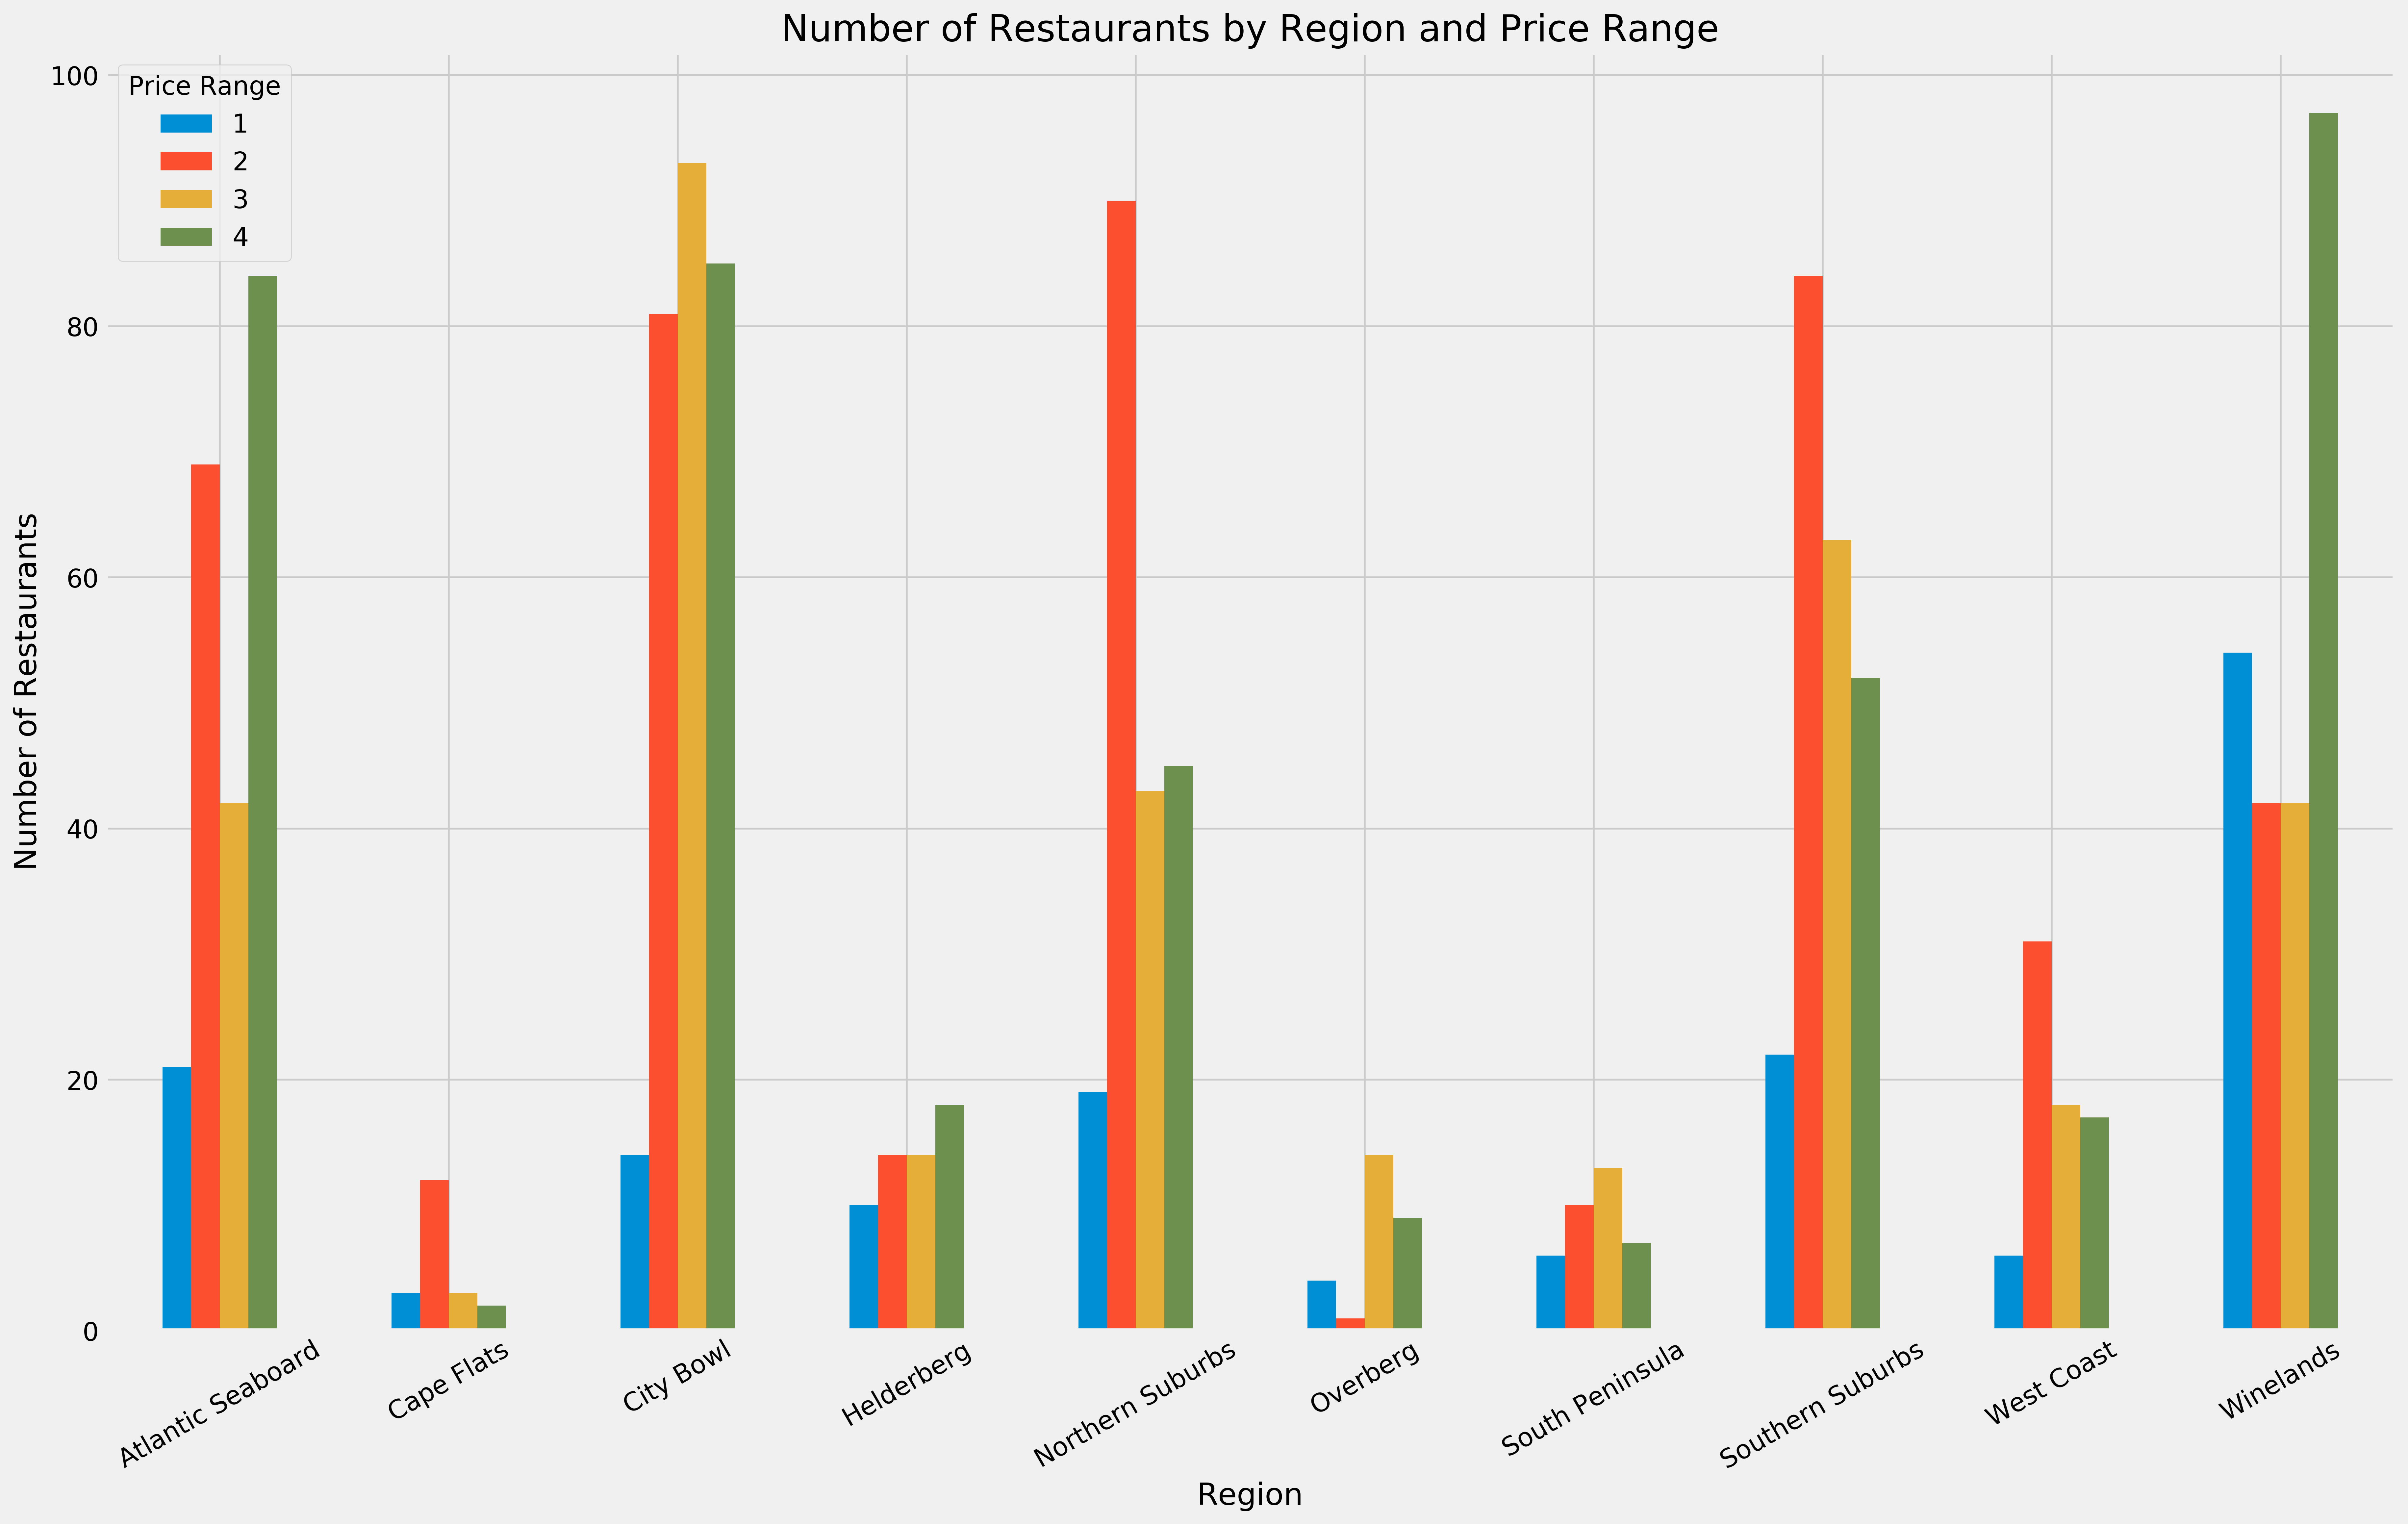

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12), dpi=400)
ax = pd.crosstab(data.region, data.price_range, margins=False).plot.bar(stacked=False, ax=ax)
ax.set_xlabel("Region")
ax.tick_params(axis="x", labelrotation=30)
ax.set_ylabel("Number of Restaurants")
ax.set_title("Number of Restaurants by Region and Price Range")
ax.legend(title="Price Range")

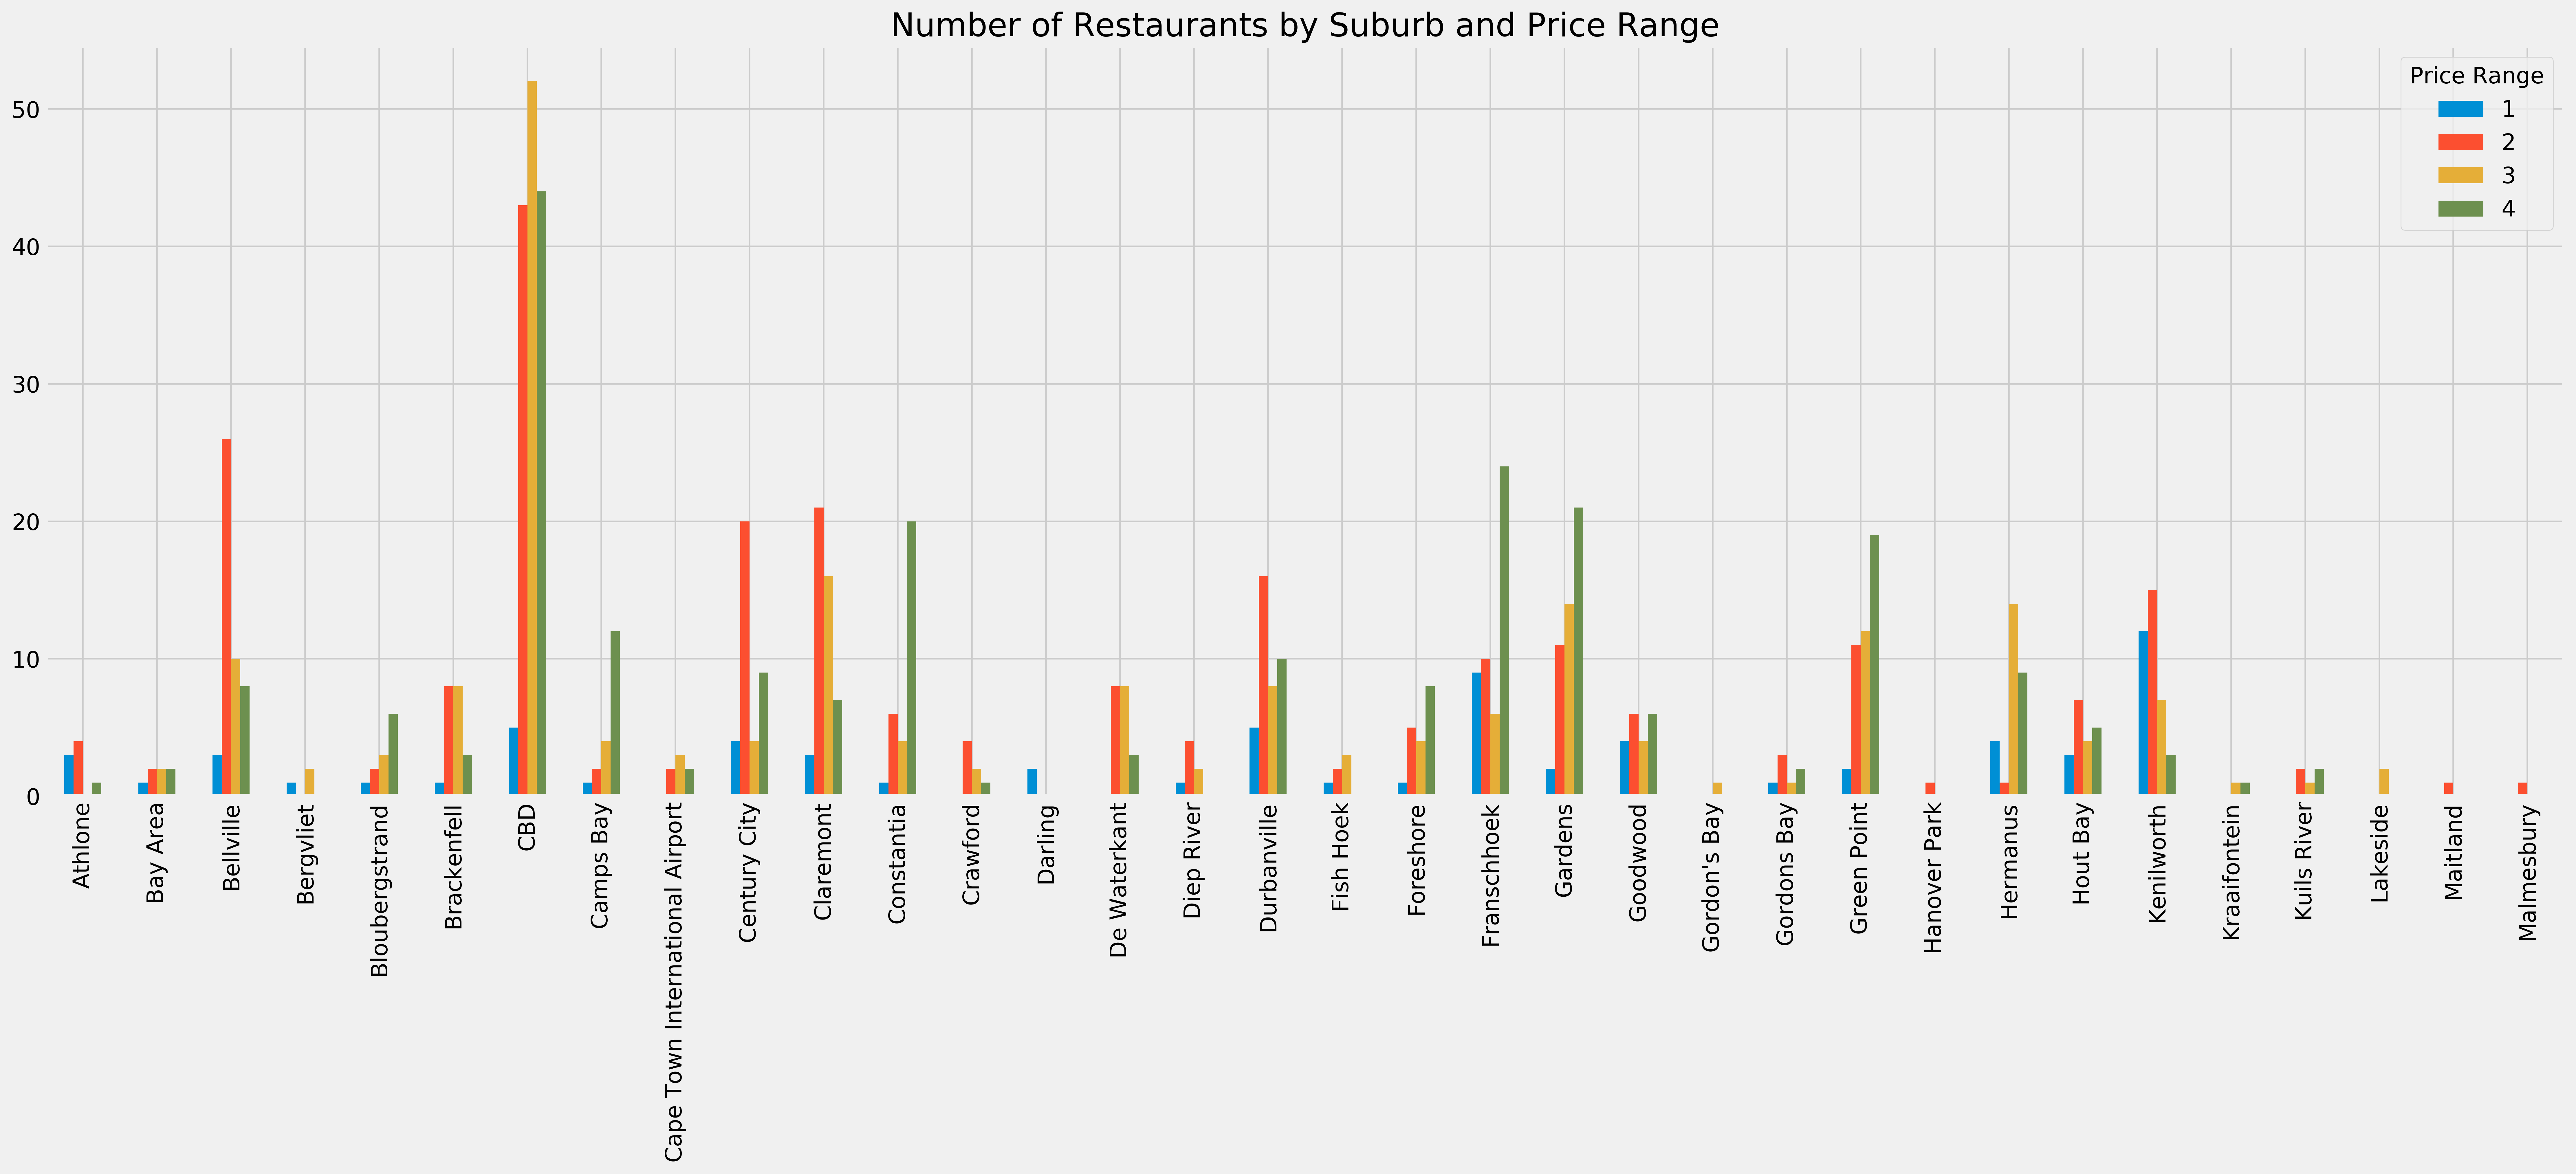

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8), dpi=400)
df = data[data.locality <= "Malmesbury"]
ax = pd.crosstab(df.locality, df.price_range, margins=False).plot.bar(stacked=False, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis="x", labelrotation=90)
ax.set_title("Number of Restaurants by Suburb and Price Range")
ax.legend(title="Price Range")

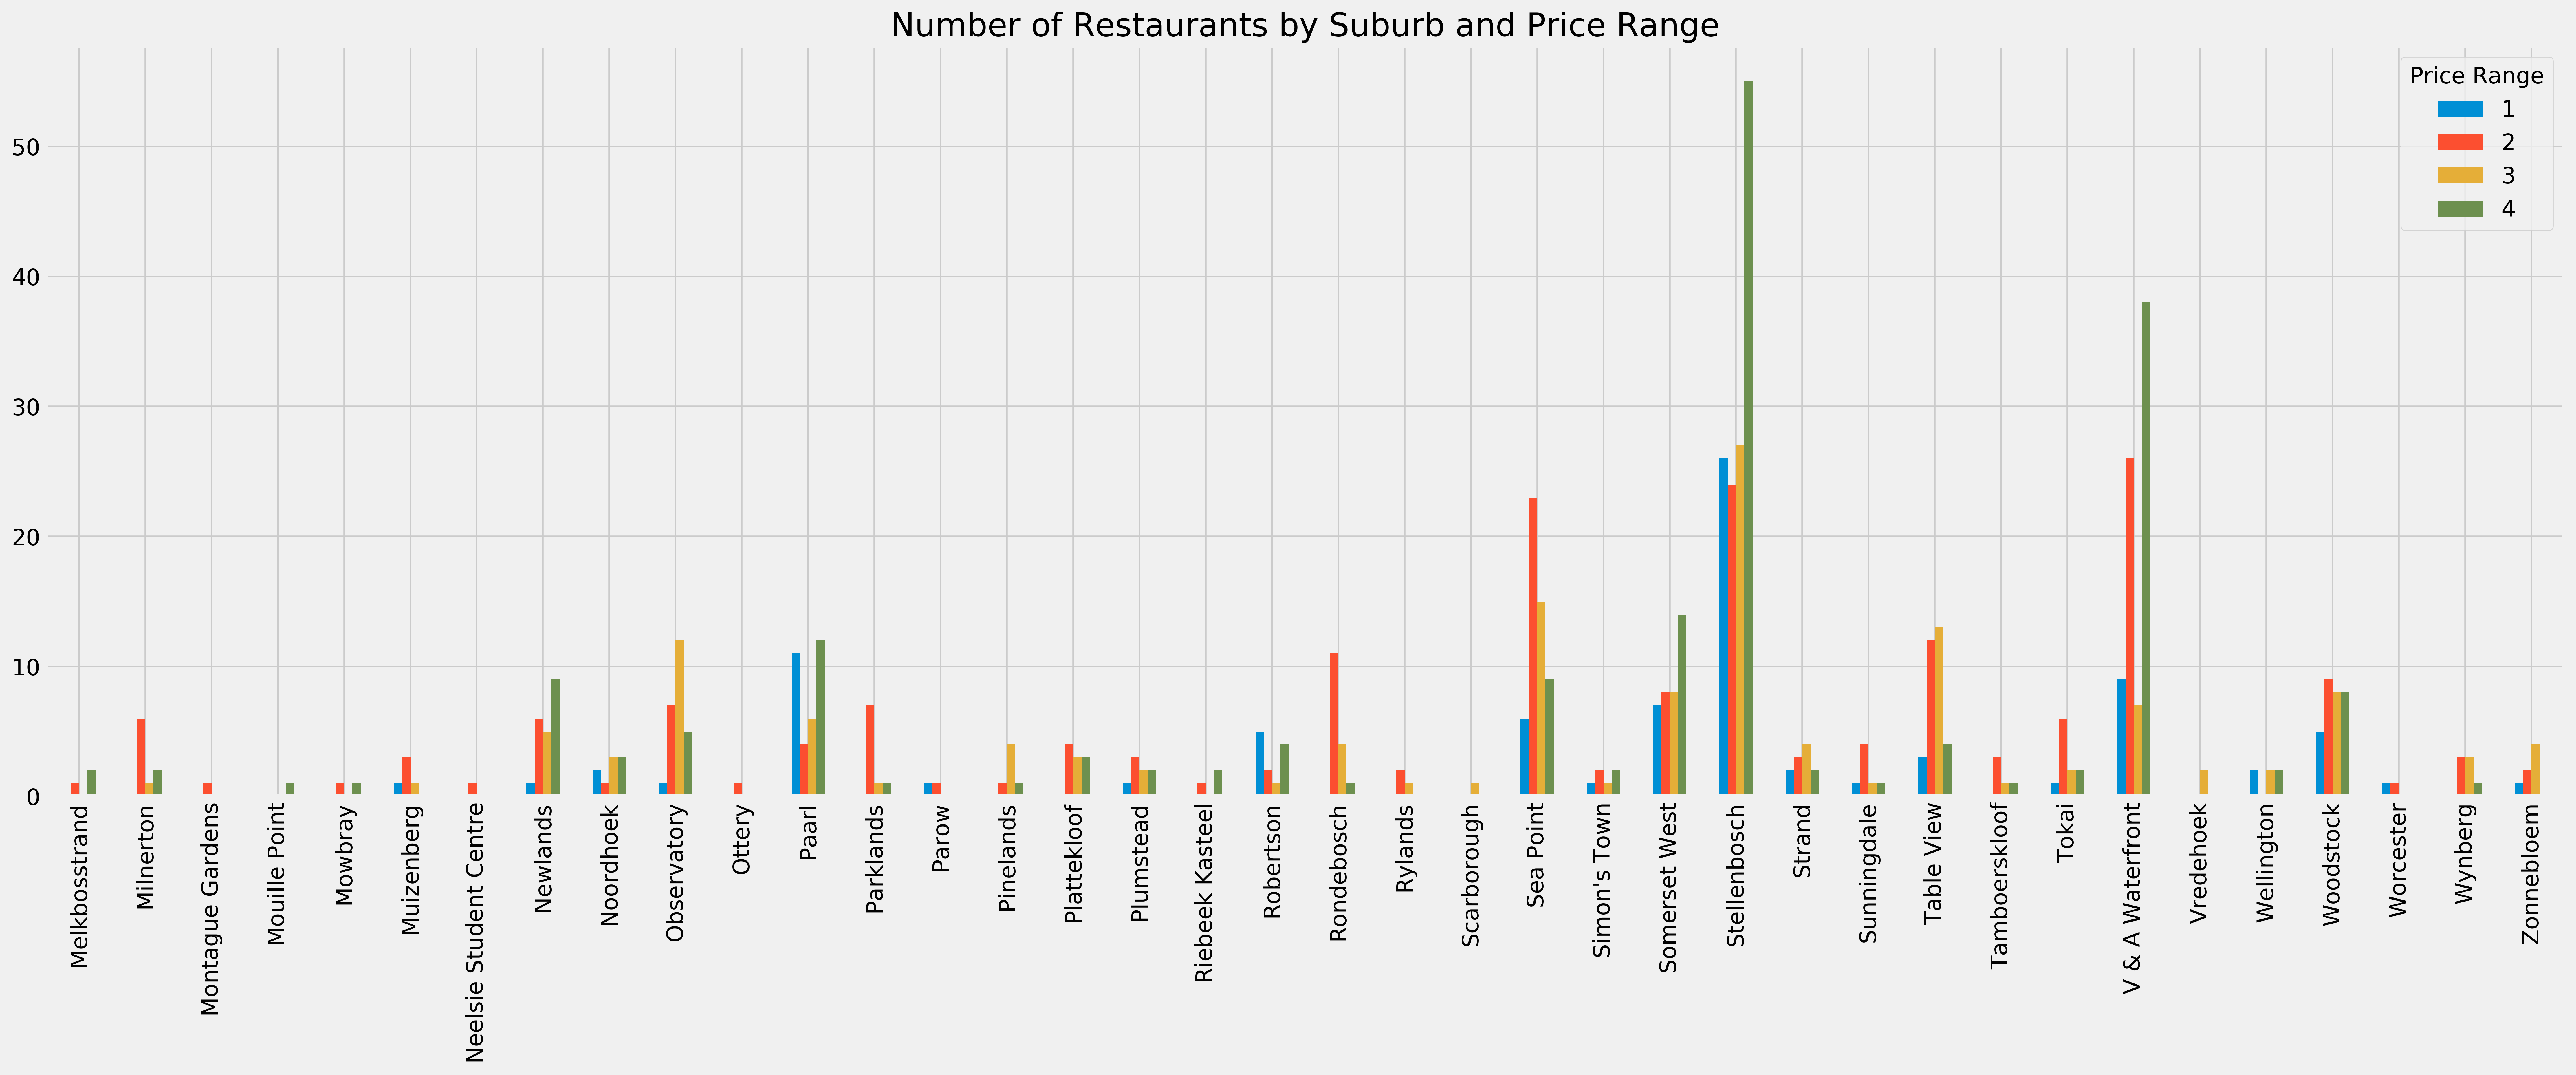

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8), dpi=400)
df = data[data.locality > "Malmesbury"]
ax = pd.crosstab(df.locality, df.price_range, margins=False).plot.bar(stacked=False, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis="x", labelrotation=90)
ax.set_title("Number of Restaurants by Suburb and Price Range")
ax.legend(title="Price Range")

## Understanding Zomato Price Ranges

In [20]:
data.pivot_table(index="price_range")["average_cost_for_two"]

price_range
1     56.037736
2    138.824885
3    229.840580
4    434.290865
Name: average_cost_for_two, dtype: float64

Text(0.5,1,'Relationship between Price Range and Average Cost for Two')

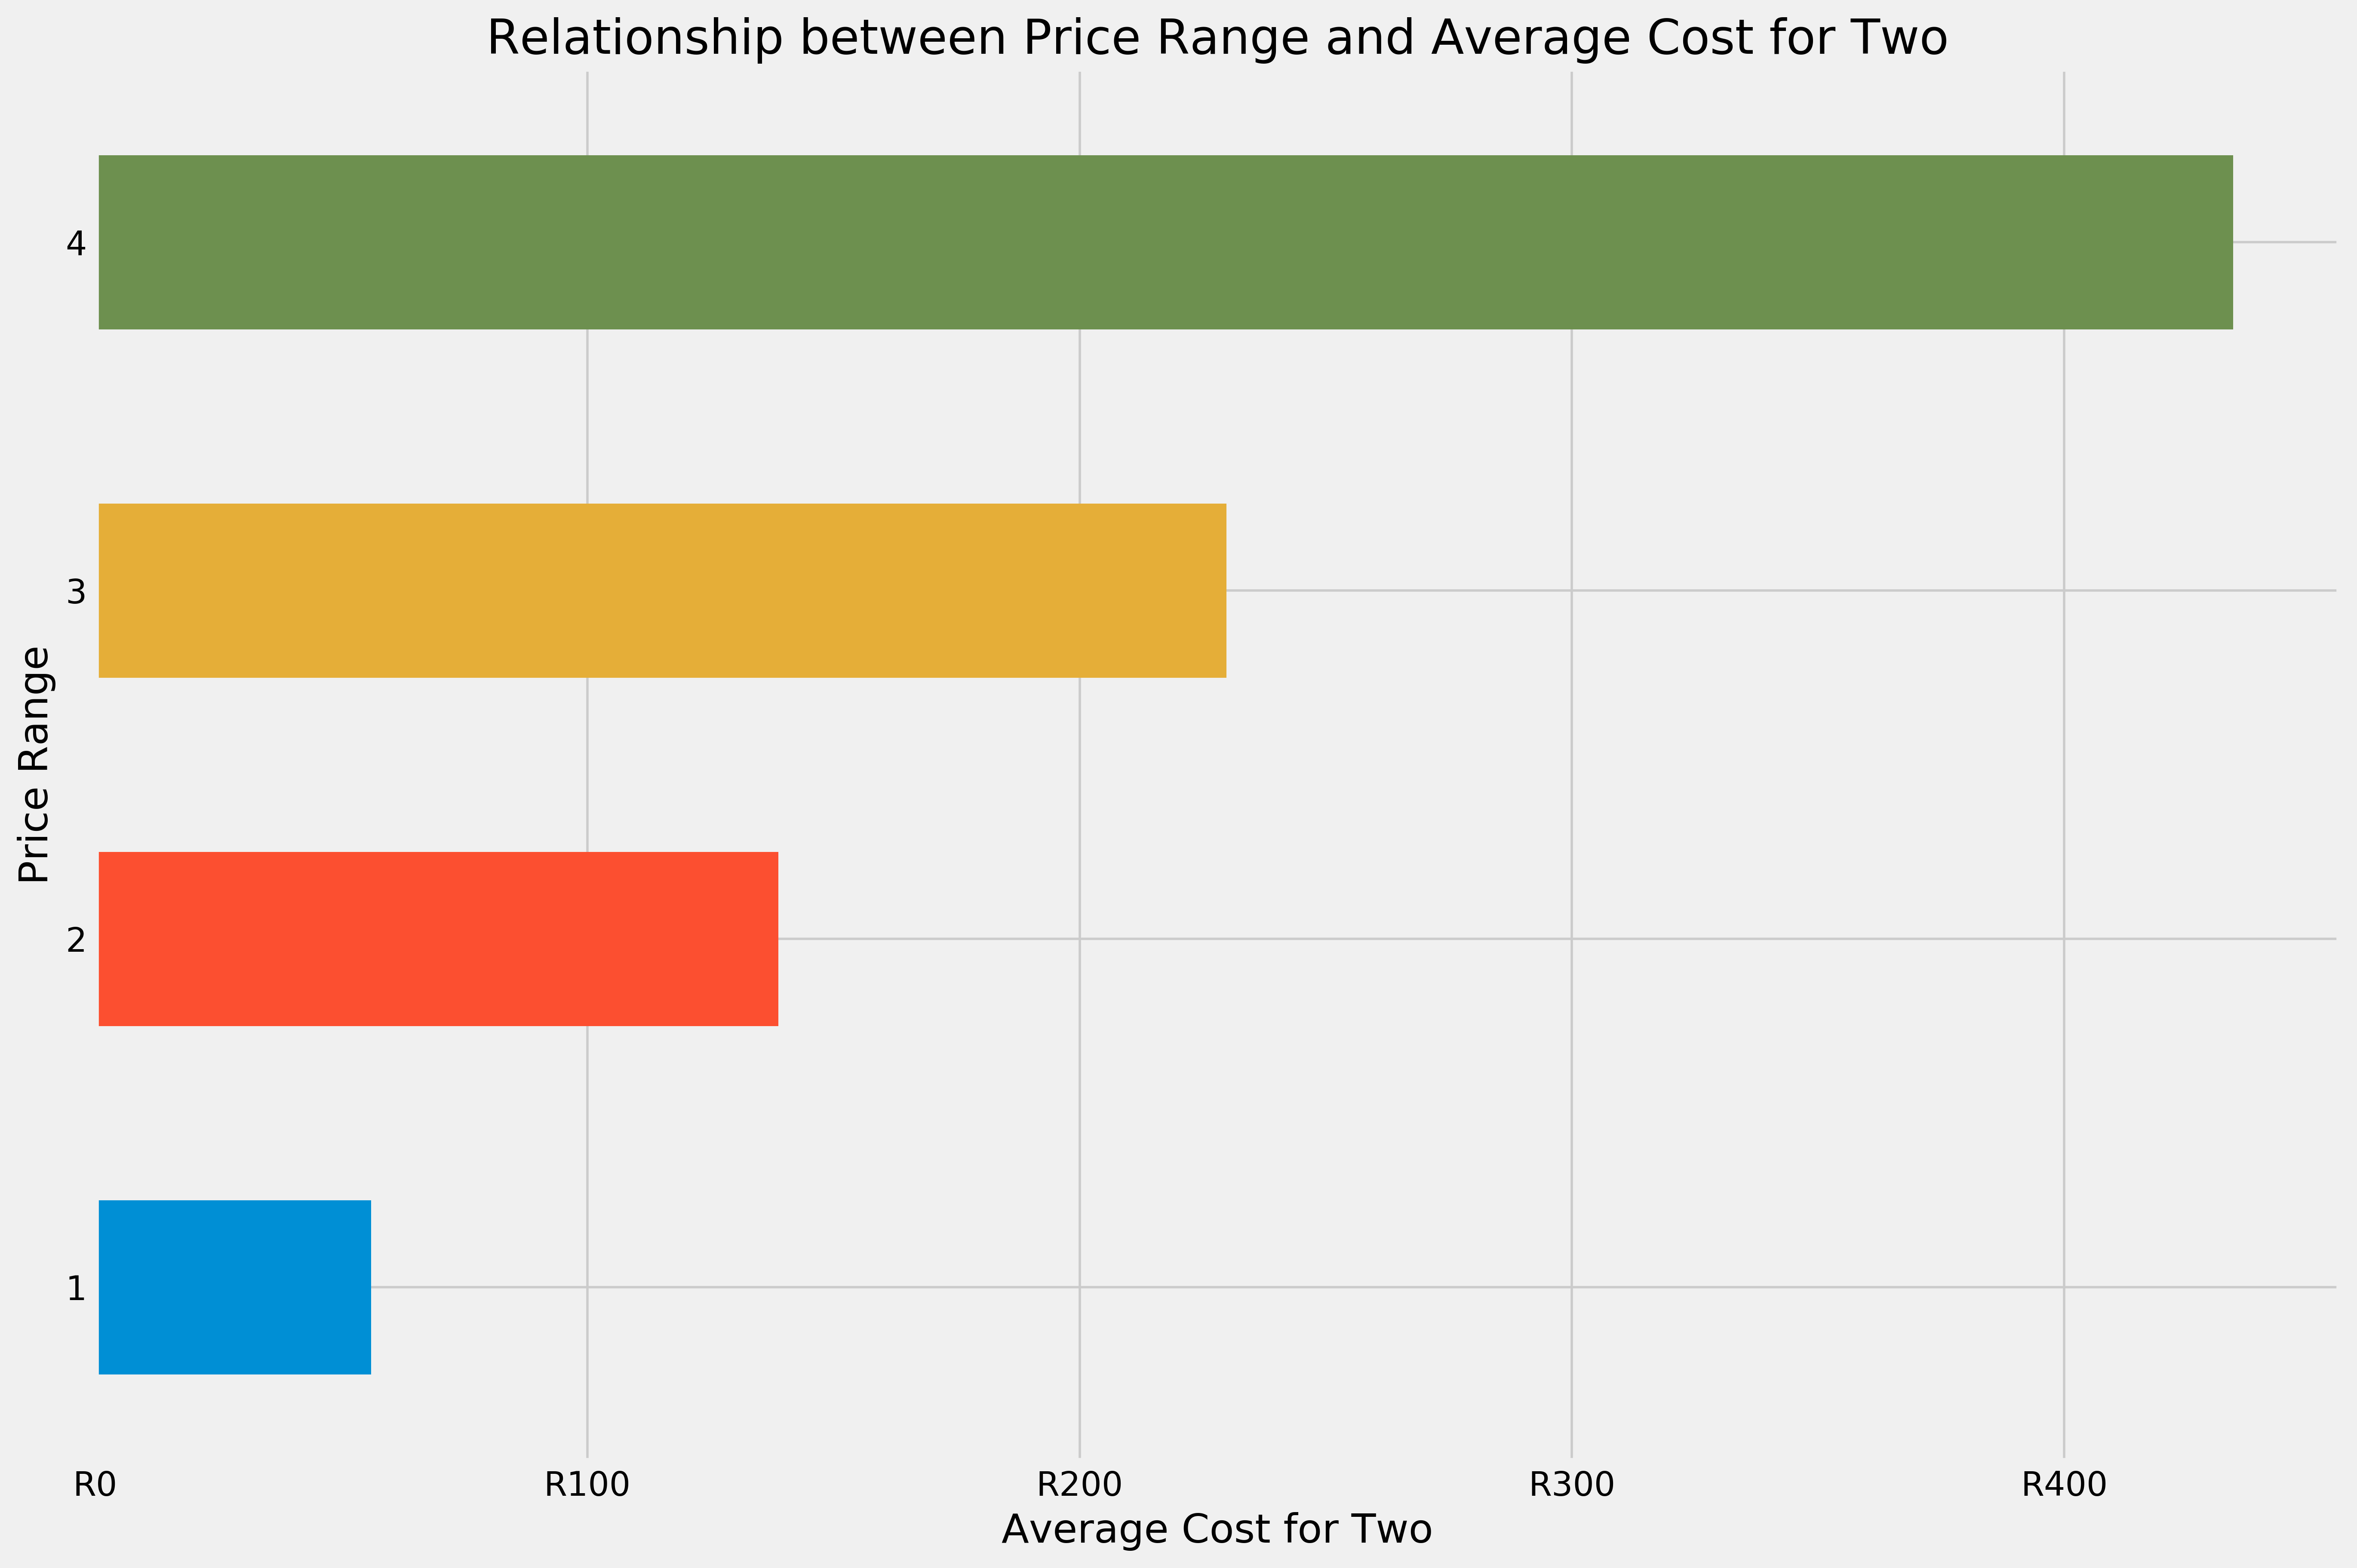

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=400)
ax = data.pivot_table(index="price_range")["average_cost_for_two"].plot.barh(ax=ax)
ax.set_xlabel("Average Cost for Two")
ax.xaxis.set_major_formatter(axes_formatter)
ax.set_ylabel("Price Range")
ax.set_title("Relationship between Price Range and Average Cost for Two")


## Ratings & Average Cost for Two Across Regions and Suburbs

In [51]:
fig, ax = plt.subplots(1, 1, dpi=400)
ax = data.pivot_table(index=["region", "price_range"]).unstack().sort_index(ascending=False)["aggregate_rating"].plot.barh(ax=ax, stacked=False, figsize=(20,20))
ax.set_xlabel("Rating")
ax.set_ylabel("")  
plt.title("Average Rating by Region")

Text(0.5,1,'Average Rating by Region')

Text(0.5,1,'Average Rating by Suburb')

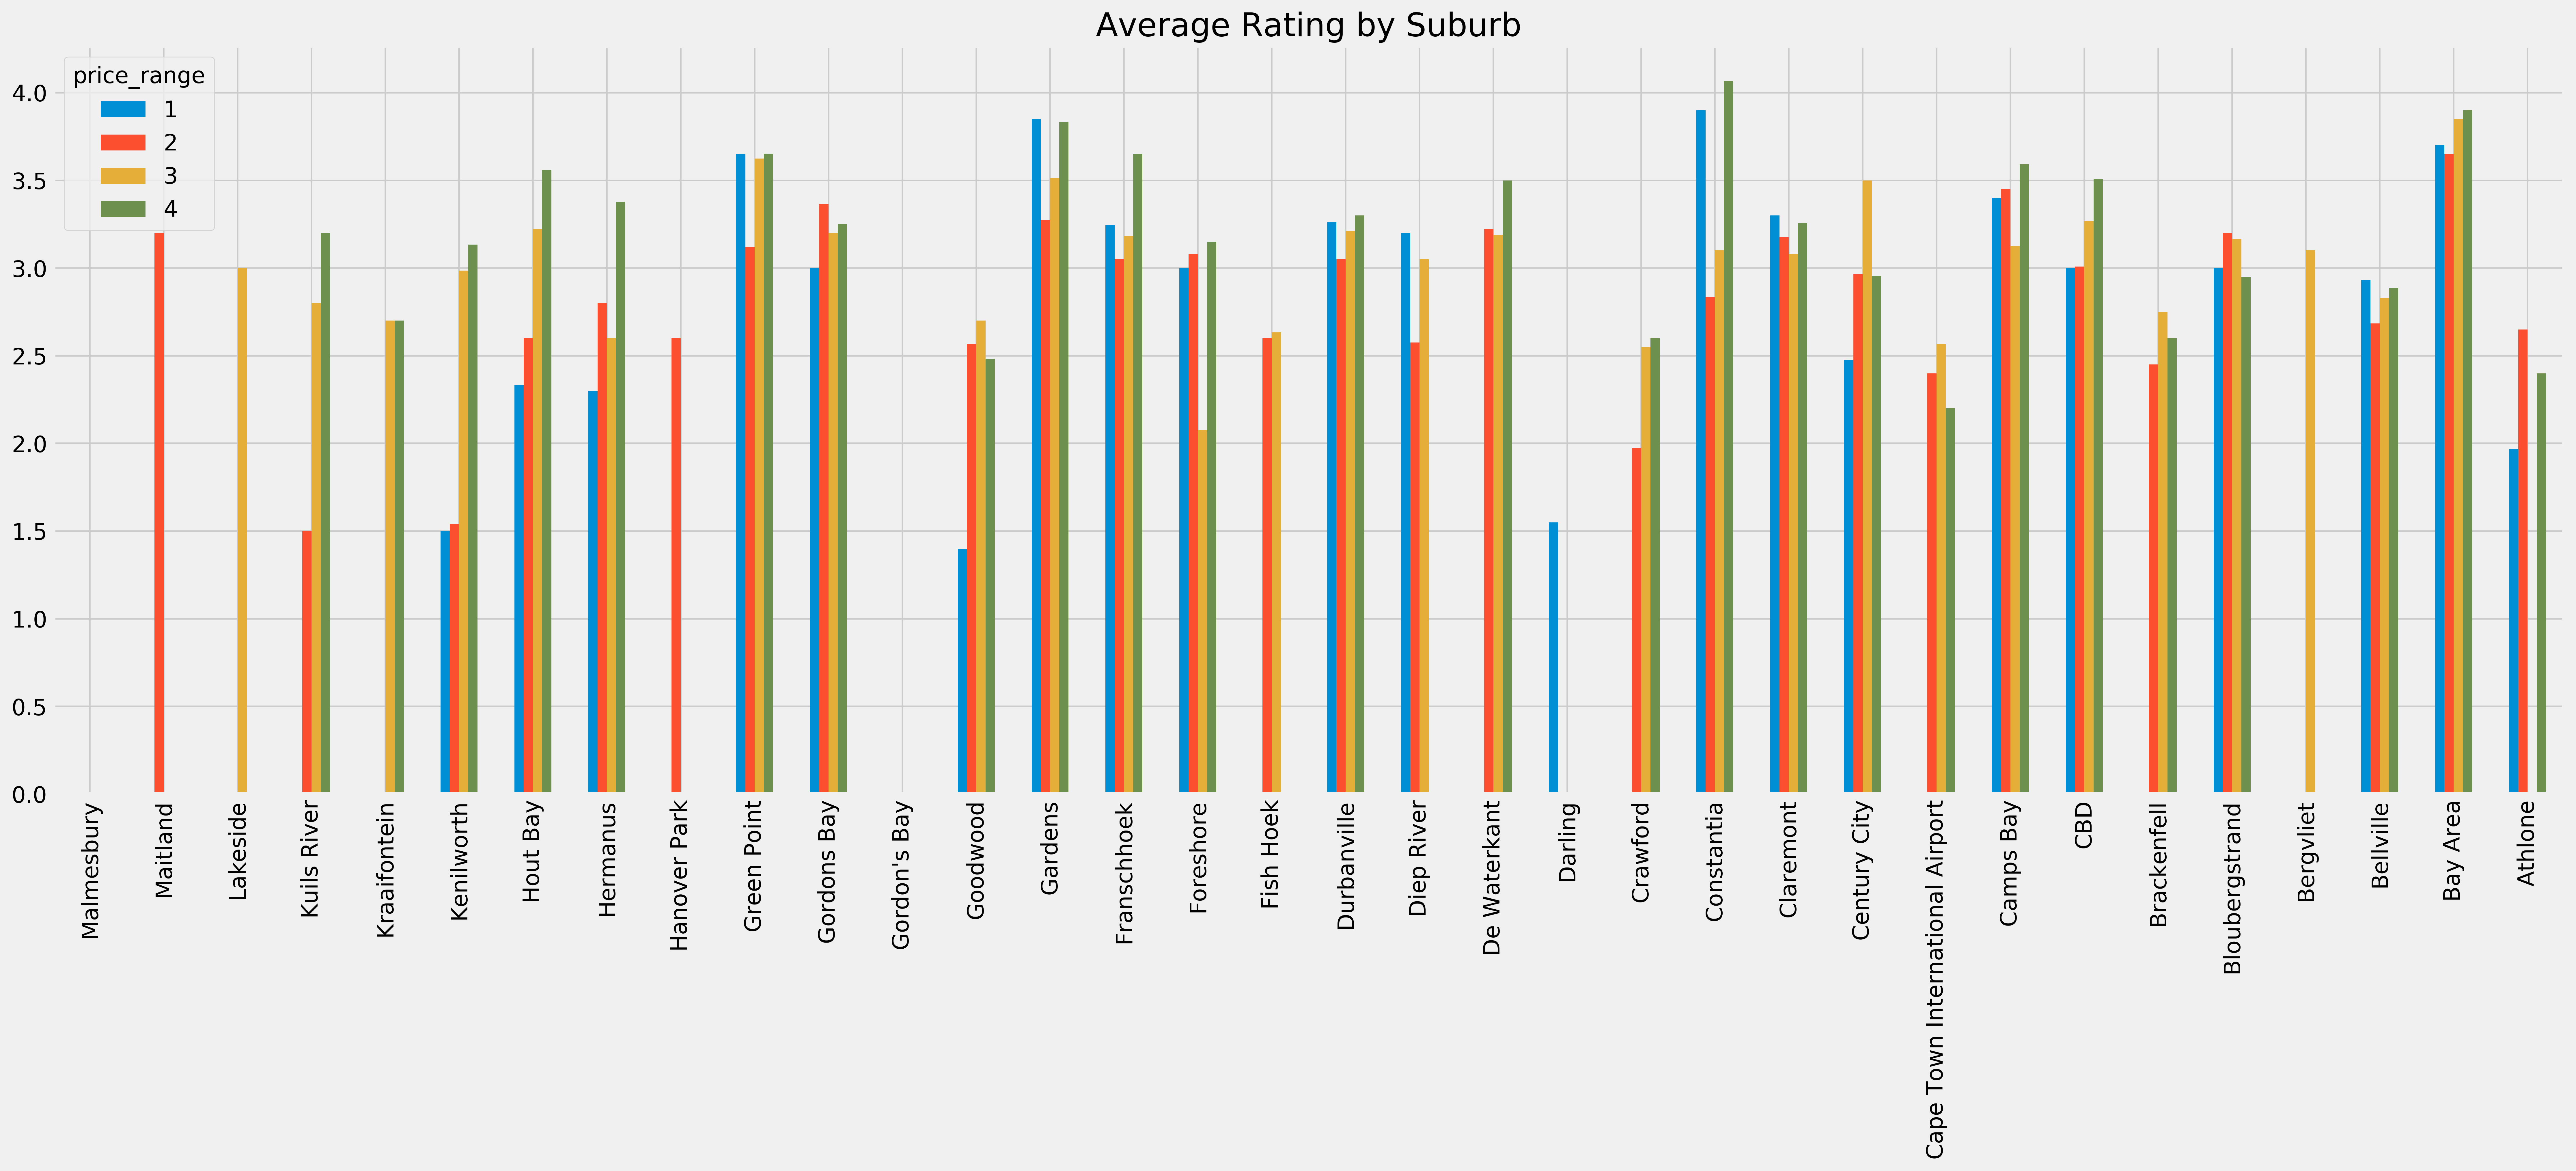

In [58]:
fig, ax = plt.subplots(1, 1, dpi=400)
df = data[data.locality <= "Malmesbury"]
ax = df.pivot_table(index=["locality", "price_range"]).unstack().sort_index(ascending=False)["aggregate_rating"].plot.bar(ax=ax, stacked=False, figsize=(25,8))
ax.set_xlabel("")
ax.set_ylabel("")  
plt.title("Average Rating by Suburb")

Text(0.5,1,'Average Rating by Suburb')

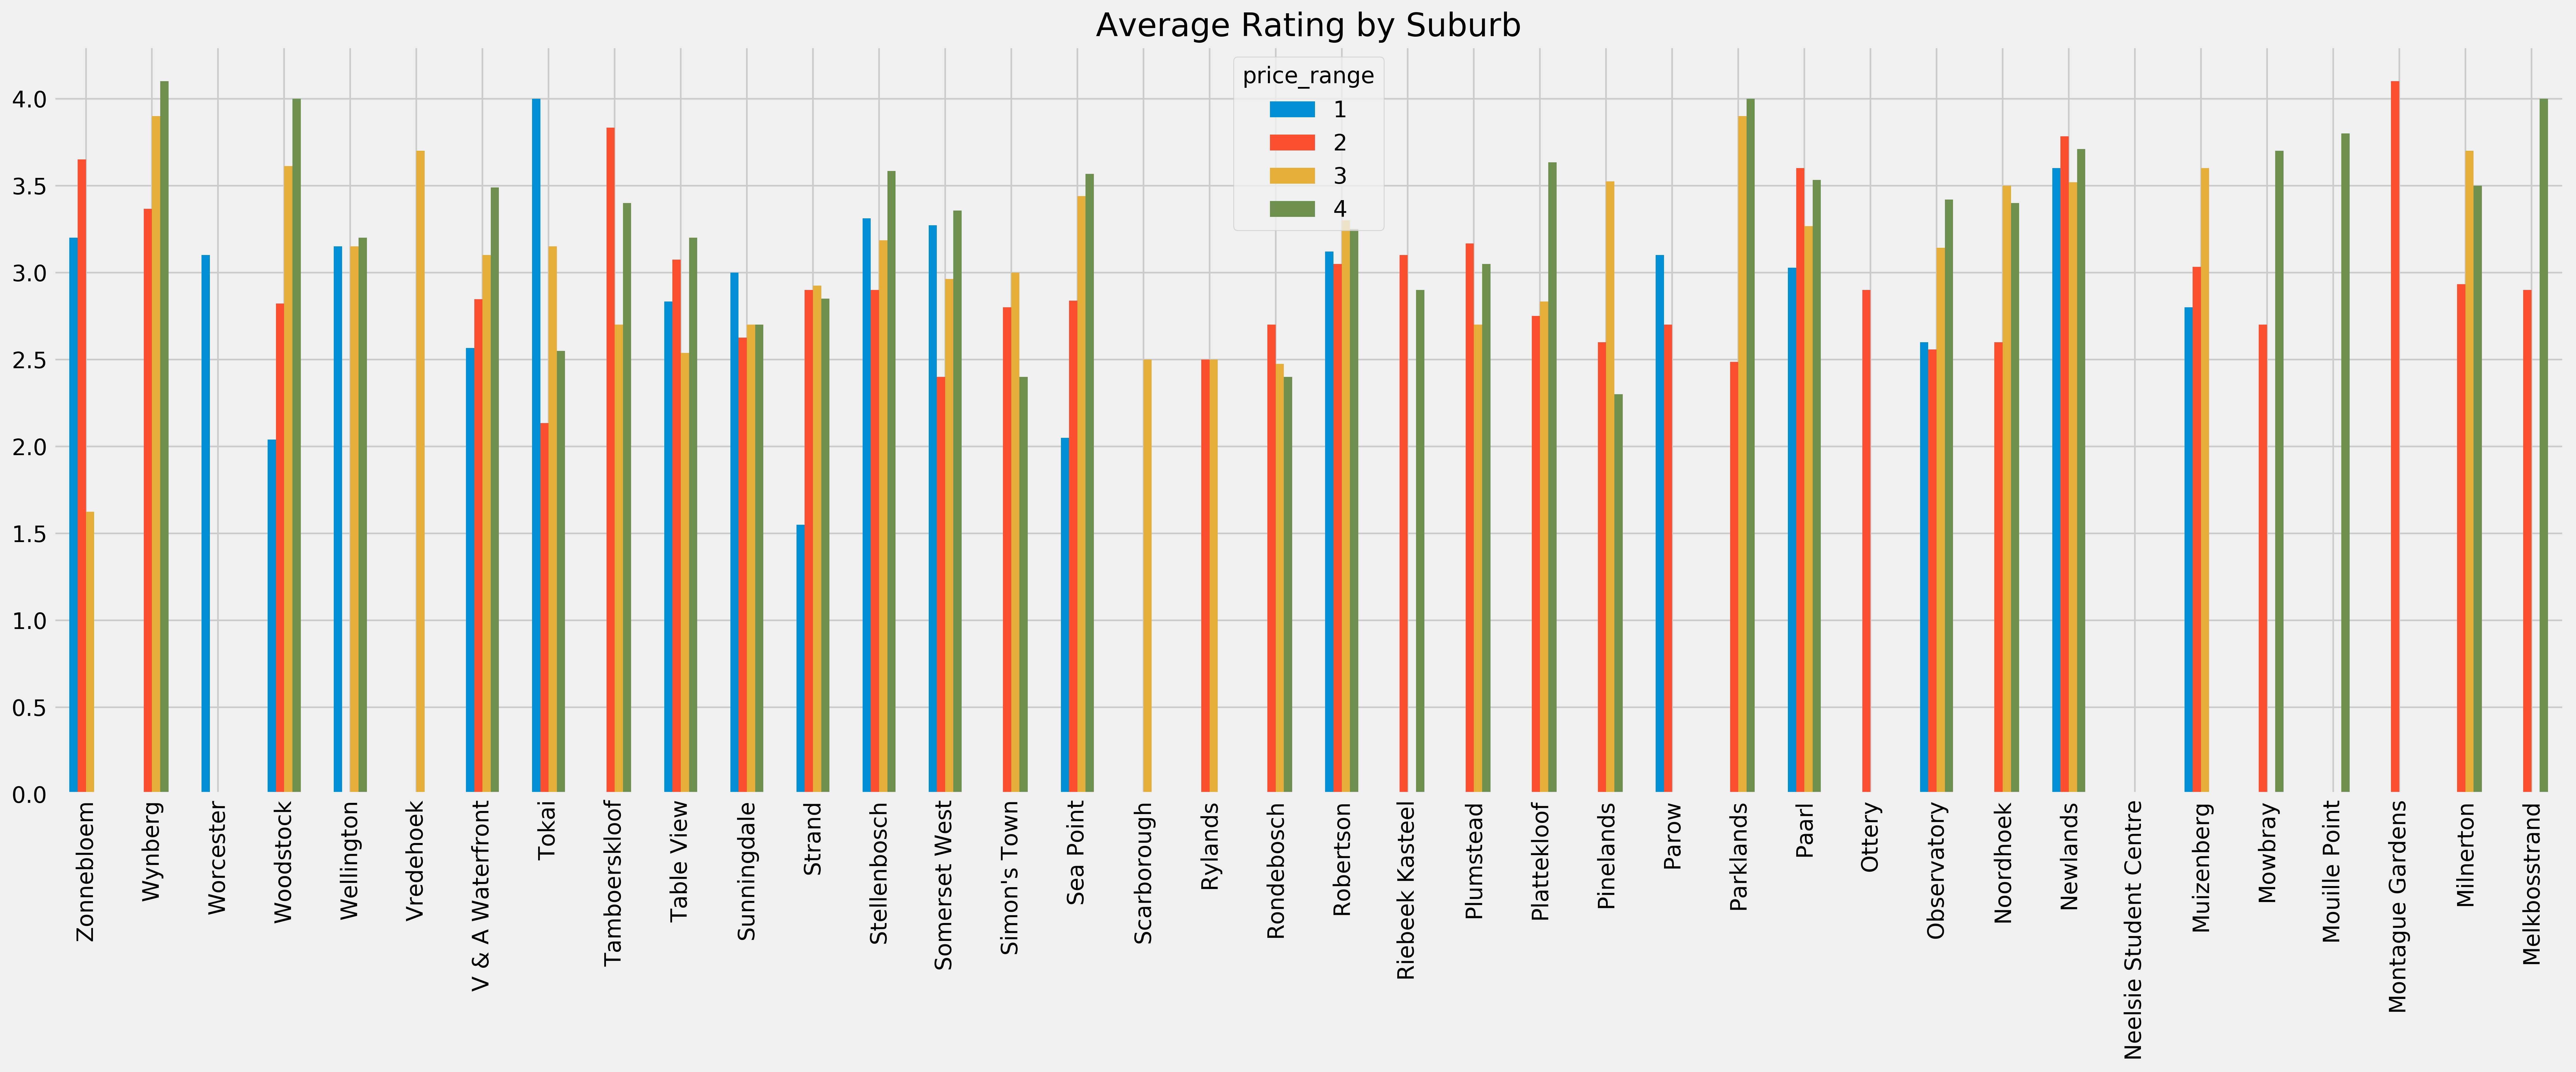

In [59]:
fig, ax = plt.subplots(1, 1, dpi=400)
df = data[data.locality > "Malmesbury"]
ax = df.pivot_table(index=["locality", "price_range"]).unstack().sort_index(ascending=False)["aggregate_rating"].plot.bar(ax=ax, stacked=False, figsize=(25,8))
ax.set_xlabel("")
ax.set_ylabel("")  
plt.title("Average Rating by Suburb")

## Cuisine Popularity by Region & Suburb

## Top and Bottom 50 by Avg. Cost, Cuisine Type and Location

## Visualising Top & Bottom Rated Regions Geographically

## Full Meal vs Drinks Only Establishments
 - count
 - rating comparison